In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pyclesperanto_prototype as cle
cle.select_device('RTX')
print("Using OpenCL device " + cle.get_device().name)

import math
import numpy as np
import pandas as pd
import cv2
import tifffile
import os
import sys
import nrrd
import cupy as cp
from cupyimg.scipy.ndimage.morphology import binary_hit_or_miss
from tqdm import tqdm
import itertools

sys.path.append("C:/Users/danie/BoneSegmentation")
from oiffile import OifFile
from src.OifImageViewer import OifImageViewer
from src.kernels import get_unique_kernels, load_from_cache

Using OpenCL device NVIDIA RTX A5000


In [2]:
!pwd

/home/dkermany/BoneSegmentation/ipynb/confocal_3D


In [3]:
from dotenv import load_dotenv
load_dotenv()

ROOTPATH = os.getenv("ROOTPATH")
BONEPATH = os.getenv("BONEPATH")
LIBPATH = os.path.join(ROOTPATH, "lib")

In [4]:
# path = "D:/Datasets/Bone_Mets/FV10__oibs/FV10__20190620_111343.oib"
# path = "/data/dkermany_data/Bone_Project/weijie_selected/main_folder/FV10__oibs/FV10__20190620_111343.oib"

path = os.path.join(BONEPATH, "weijie_selected/main_folder/FV10__oibs/FV10__20181106_172421.oib")

filename = os.path.splitext(os.path.basename(path))[0]

with OifFile(path) as oif:
    viewer = OifImageViewer(oif)
    x_step, y_step, z_step = map(float, (viewer.md["x_step"], viewer.md["y_step"], viewer.md["z_step"]))
    if viewer.md["z_unit"] == "nm":
        z_step /= 1000.

In [5]:
# import napari

# # Crop image for students
# def crop_3d_image(image: np.ndarray) -> np.ndarray:
#     image = image[:, 1300:1800, 2500:3000]
#     print(image.shape)
#     plt.figure(figsize=(15,15))
#     plt.axis("off")
#     cle.imshow(cle.push(image))
    
#     plt.figure(figsize=(15,15))
#     plt.axis("off")
#     viewer = napari.view_image(image)
#     plt.imshow(np.max(image, axis=0), cmap="Reds")
# #     np.save(f"/home/dkermany/cropped_{filename}.npy", image)
    
# # get NG2 channel
# image = viewer.get_array()[1]
# crop_3d_image(image)
# del image

In [6]:
# import napari
# viewer = napari.view_image(cropped_one_segment)

Load 3D Masks
----------------------

(77, 1969, 7127)
uint16


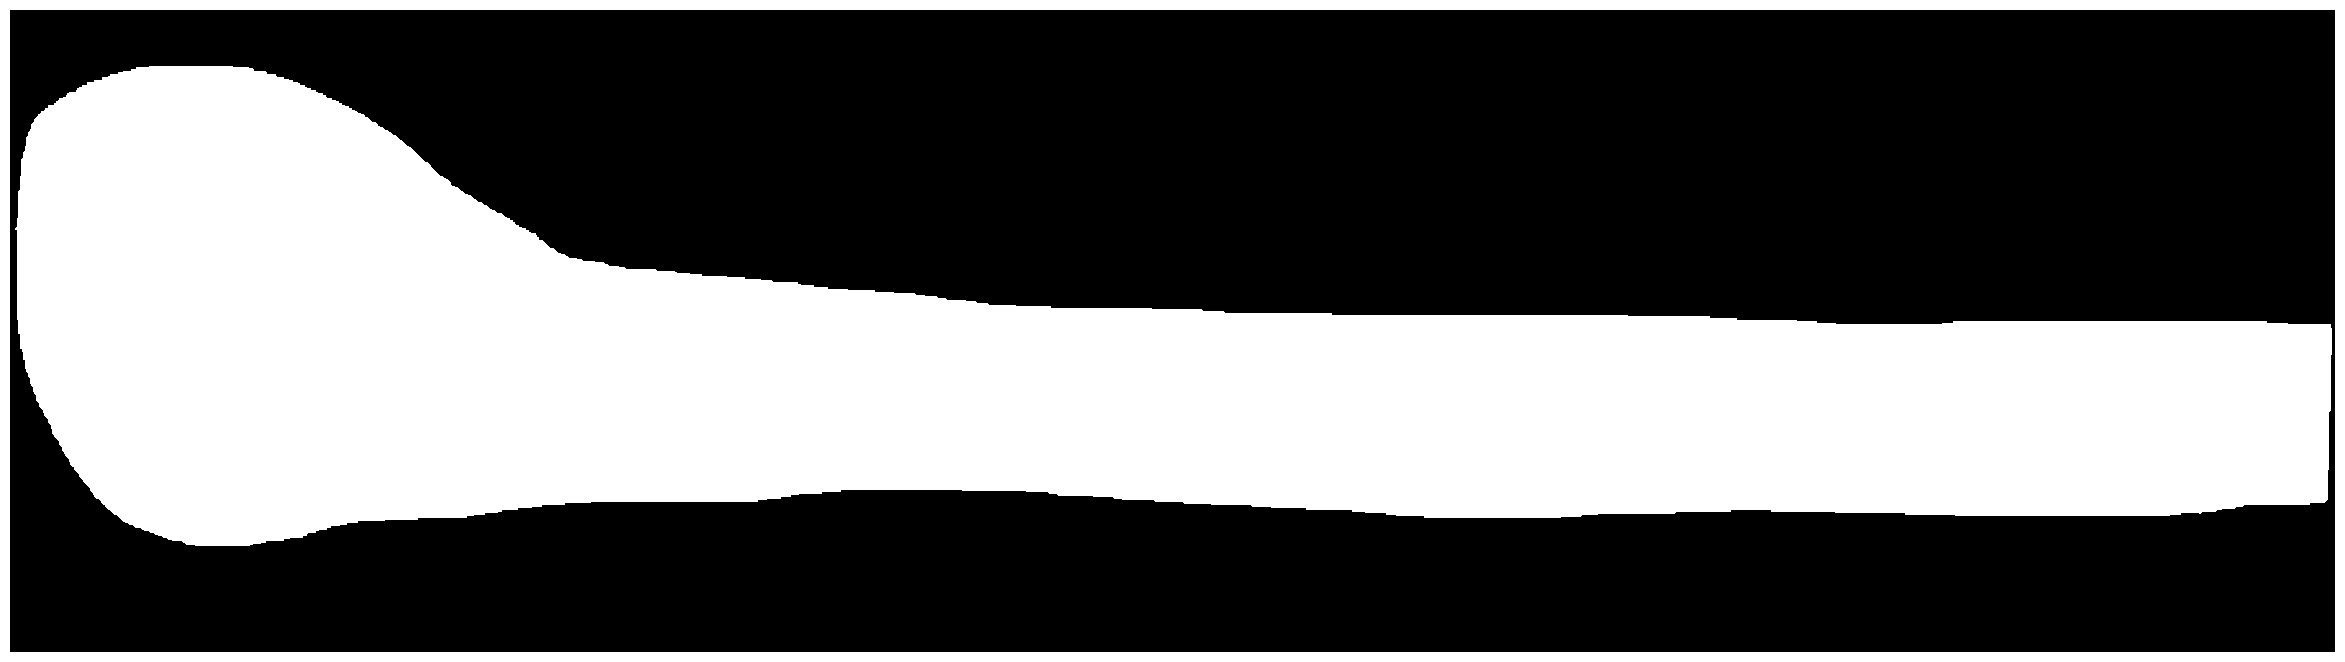

In [7]:
mask_path = os.path.join(BONEPATH, f"masks/{filename}.seg.nrrd")
# mask_path = f"D:/Datasets/Bone_Mets/masks/{filename}.seg.nrrd"

# Load mask from NRRD
mask, header = nrrd.read(mask_path)
mask = mask.T
# mask = mask[:mask.shape[0]//3, :, :] #For FV10__20190620_111343

# Convert mask from uint8 to uint16
mask = mask.astype(np.uint16)
mask *= 2**16 - 1
print(mask.shape)
print(mask.dtype)

plt.figure(figsize=(30,15))
plt.axis("off")
cle.imshow(mask[40])

(77, 1969, 7127)


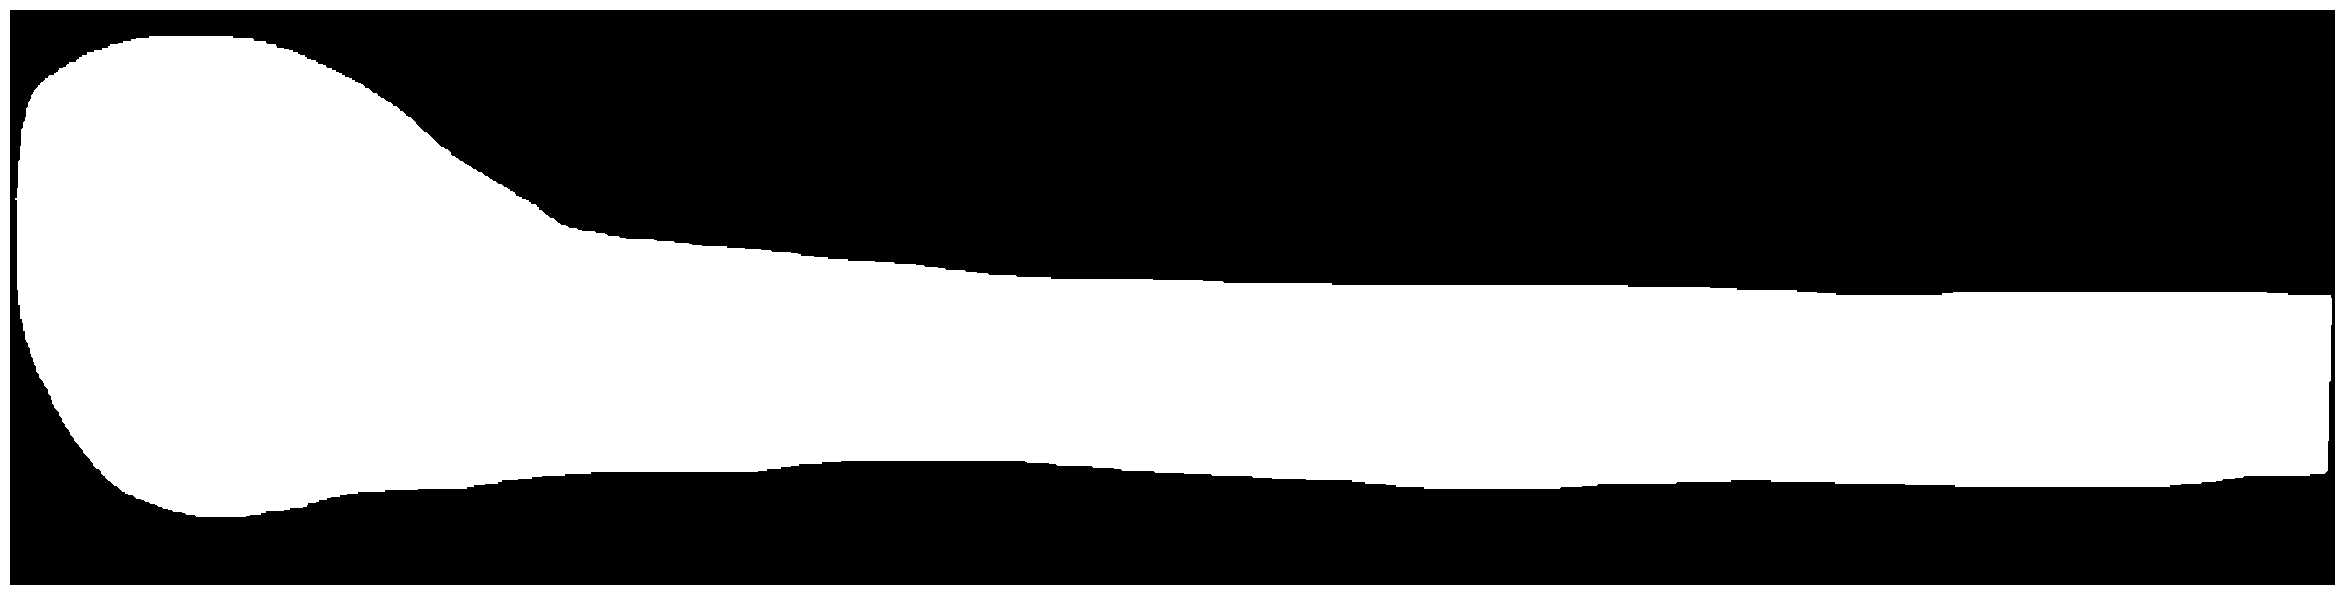

(77, 1763, 7127)


In [8]:
print(mask.shape)
z = np.any(mask, axis=(1, 2))
y = np.any(mask, axis=(0, 2))
x = np.any(mask, axis=(0, 1))

z_min, z_max = np.where(z)[0][[0, -1]]
y_min, y_max = np.where(y)[0][[0, -1]]
x_min, x_max = np.where(x)[0][[0, -1]]

# Crop the array
cropped_array = mask[z_min:z_max+1, y_min:y_max+1, x_min:x_max+1]

plt.figure(figsize=(30,15))
plt.axis("off")
cle.imshow(cropped_array[40])
print(cropped_array.shape)


In [10]:
tumor_csv_path = os.path.join(BONEPATH, "tumor_locations_02_08_2023.csv")
# tumor_csv_path = f"D:/Datasets/Bone_Mets/tumor_locations/tumor_locations_02_08_2023.csv"

# Load csv and drop rows with N/A's
tumor_csv = pd.read_csv(tumor_csv_path).dropna()
tumor_csv

Filename  x (um)  y (um)  z (slice)
0    FV10__20190620_111343  2987.0  1760.0       76.0
1    FV10__20190620_111343  2975.0  1755.0       76.0
2    FV10__20190620_111343  2953.0  1715.0       76.0
3    FV10__20190620_111343  3079.0  1680.0       76.0
4    FV10__20190620_111343  2815.0  1342.0       76.0
..                     ...     ...     ...        ...
818  FV10__20190619_111005  6508.0  1024.0       31.0
819  FV10__20190619_111005  6516.0   947.0       32.0
820  FV10__20190619_111005  6211.0  1197.0       31.0
821  FV10__20190619_111005  6565.0  1229.0       35.0
822  FV10__20190619_111005  6274.0  1236.0       23.0

[816 rows x 4 columns]


Tumor Location Marking
----------------------

In [11]:
# Filter tumors for the image in focus
tumor_csv = tumor_csv[tumor_csv.Filename == filename].reset_index(drop=True)
tumor_csv
print()

In [12]:
tumor_dict = tumor_csv.to_dict("index")
tumor_dict

{0: {'Filename': 'FV10__20181106_172421',
  'x (um)': 116.0,
  'y (um)': 1690.0,
  'z (slice)': 55.0},
 1: {'Filename': 'FV10__20181106_172421',
  'x (um)': 184.0,
  'y (um)': 1409.0,
  'z (slice)': 13.0},
 2: {'Filename': 'FV10__20181106_172421',
  'x (um)': 118.0,
  'y (um)': 1483.0,
  'z (slice)': 30.0},
 3: {'Filename': 'FV10__20181106_172421',
  'x (um)': 2240.0,
  'y (um)': 1023.0,
  'z (slice)': 63.0},
 4: {'Filename': 'FV10__20181106_172421',
  'x (um)': 2562.0,
  'y (um)': 1128.0,
  'z (slice)': 62.0},
 5: {'Filename': 'FV10__20181106_172421',
  'x (um)': 2514.0,
  'y (um)': 1098.0,
  'z (slice)': 43.0},
 6: {'Filename': 'FV10__20181106_172421',
  'x (um)': 2244.0,
  'y (um)': 1037.0,
  'z (slice)': 40.0},
 7: {'Filename': 'FV10__20181106_172421',
  'x (um)': 2231.0,
  'y (um)': 1008.0,
  'z (slice)': 37.0},
 8: {'Filename': 'FV10__20181106_172421',
  'x (um)': 2843.0,
  'y (um)': 1375.0,
  'z (slice)': 48.0},
 9: {'Filename': 'FV10__20181106_172421',
  'x (um)': 2241.0,
  'y 

In [13]:
len(tumor_dict)

23

To calculate the radius of a circle formed by looking at a z-slice of a sphere, you can use the following formula:

radius = sqrt(r^2 - z^2)

where r is the radius of the sphere and z is the distance from the center of the sphere to the z-slice. This formula assumes that the z-slice is perpendicular to the center of the sphere.

For example, suppose you have a sphere with a radius of 5 units and you want to find the radius of the circle formed by a z-slice that is 2 units away from the center of the sphere. In this case, you would plug the values into the formula like this:

radius = sqrt(5^2 - 2^2)
= sqrt(25 - 4)
= sqrt(21)
= 3.605551275463989

So the radius of the circle would be approximately 3.61 units.

In [14]:
tumor_labels = np.zeros(viewer._arr.shape[1:], dtype=np.uint16)

for idx, tumor_info in tumor_dict.items():
    x_um, y_um, z_slice = map(int, (tumor_info["x (um)"], tumor_info["y (um)"], tumor_info["z (slice)"]))
    x, y, z = map(int, (x_um / x_step, y_um / y_step, z_slice-1))
    print(x, y, z)
    
    sphere_radius = 7 # micron
    sphere_z_slices = math.ceil(sphere_radius / z_step)
    
    min_z_step = max(0, z-sphere_z_slices)
    max_z_step = min(z+sphere_z_slices, viewer._arr.shape[1])

    # Label tumor
    for z_prime in range(min_z_step, max_z_step):
        cv2.circle(
            tumor_labels[z_prime],
            (x, y),
            radius=round((sphere_radius**2 - min((z_step*abs(z_prime-z))**2, sphere_radius**2))**0.5),
            color=(4096,4096,4096),
            thickness=-1,
        )
print(tumor_labels.shape)

93 1360 54
148 1134 12
95 1194 29
1803 823 62
2062 908 61
2024 884 42
1806 834 39
1796 811 36
2289 1107 47
1804 1485 7
2037 1417 20
1962 1267 29
1675 1318 74
1899 1285 75
1683 1351 71
3091 931 11
2998 933 70
3310 1446 58
1214 544 76
1297 592 69
1343 755 69
1366 768 67
1190 1414 40
(77, 1969, 7127)


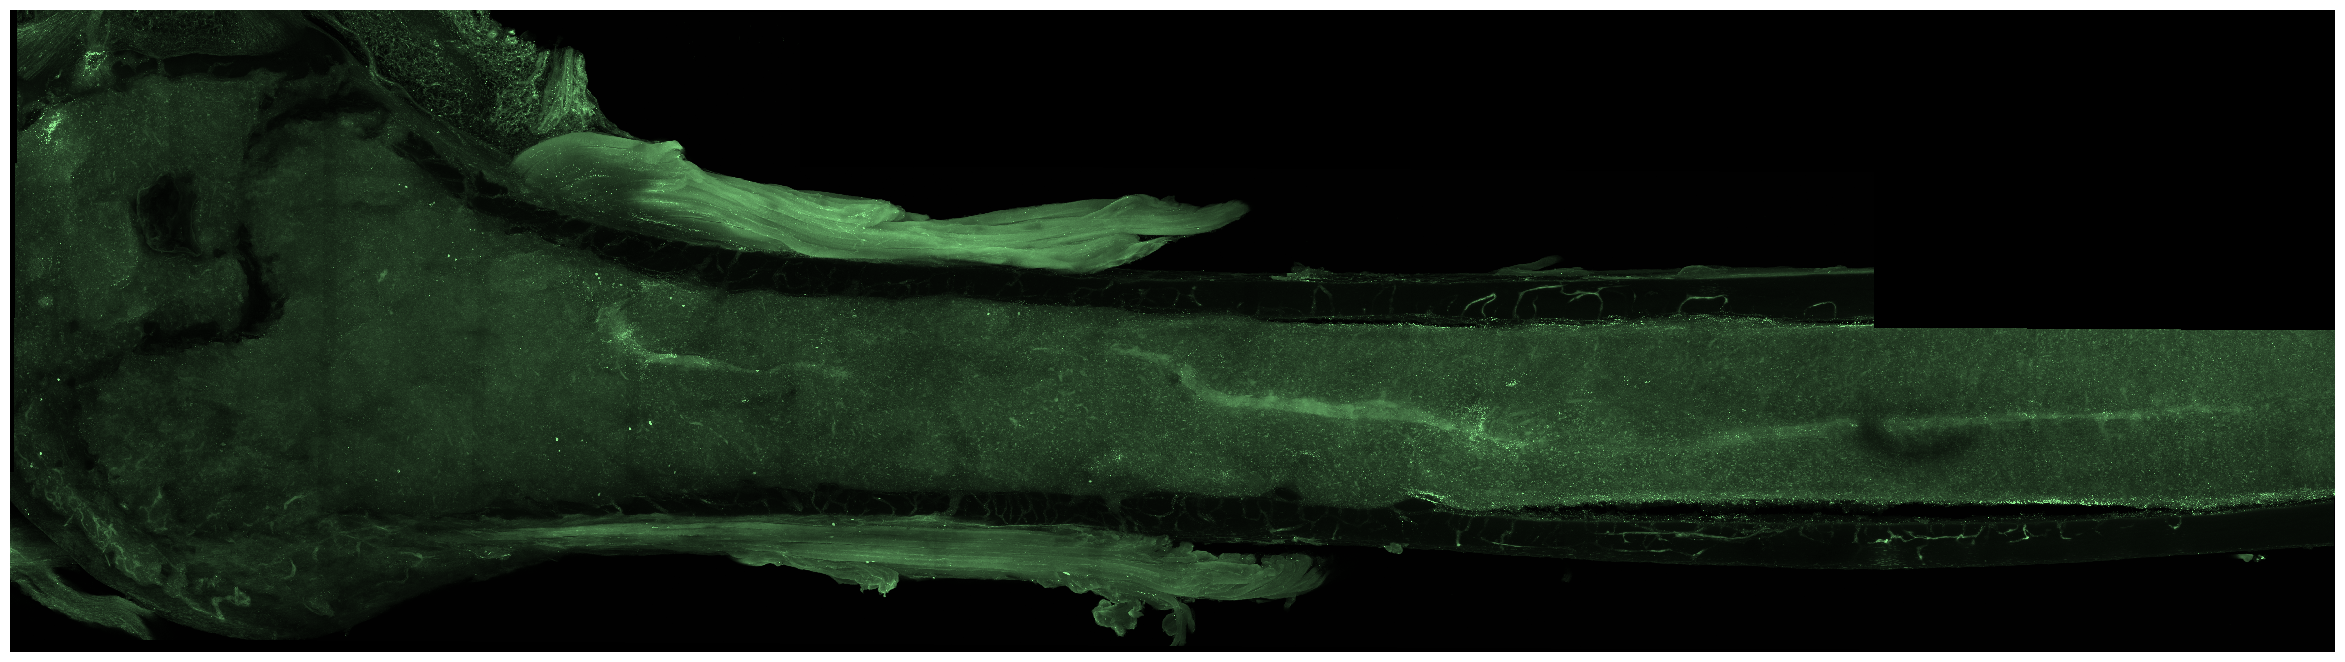

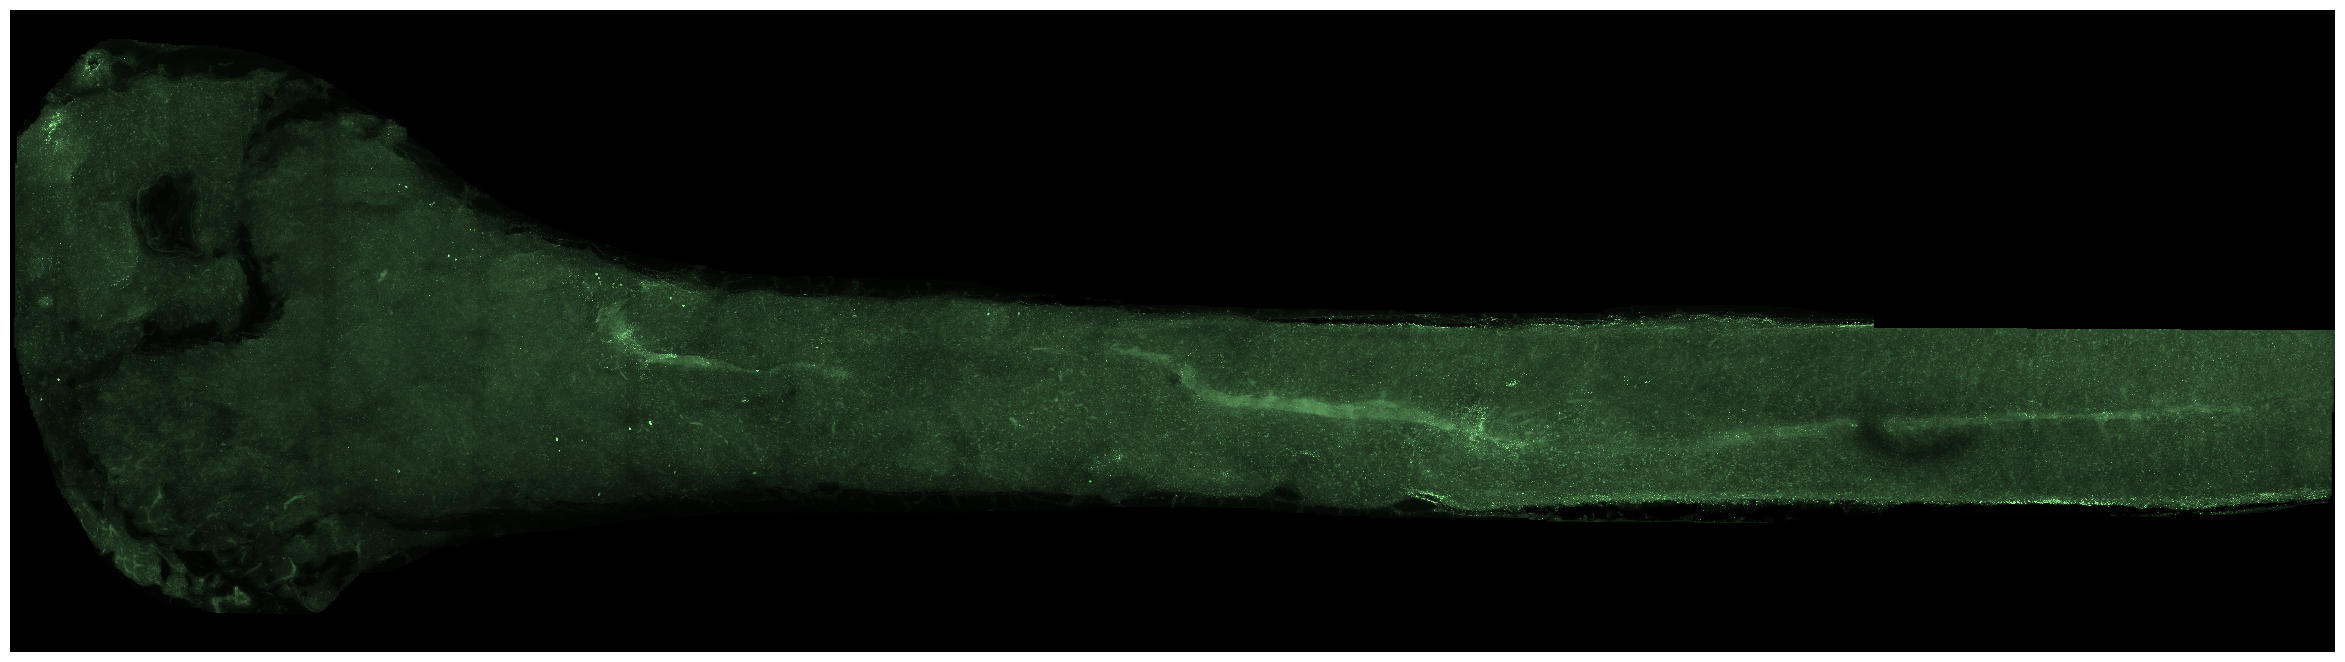

In [15]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "lightgreen"])

original_tumor = cle.push(viewer.get_array()[0])
plt.figure(figsize=(30,15))
plt.axis("off")
cle.imshow(original_tumor, colormap=cmap)

masked_tumor = cle.mask(original_tumor, mask)
plt.figure(figsize=(30,15))
plt.axis("off")
cle.imshow(masked_tumor, colormap=cmap)



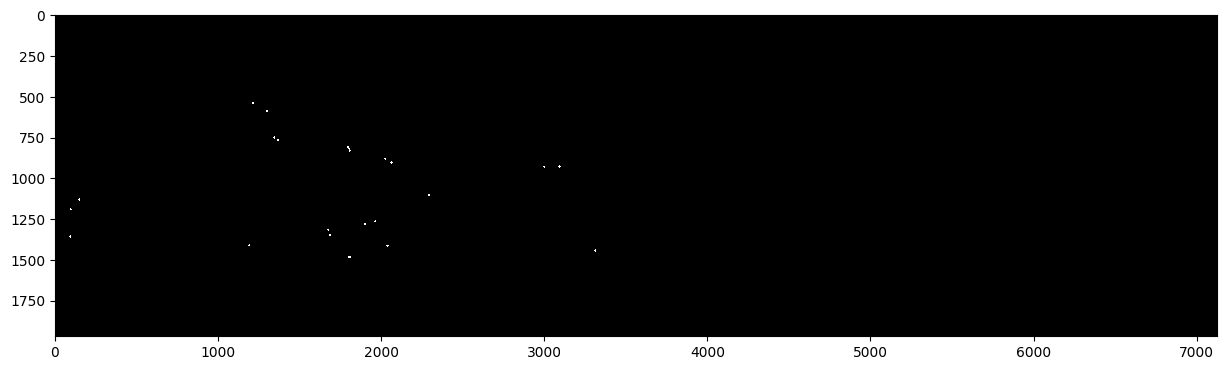

In [16]:
# total_image = np.concatenate((viewer._arr, np.expand_dims(tumor_labels, axis=0)), axis=0)
# print(total_image.shape)
# print("Total Image type:", total_image.dtype)
plt.figure(figsize=(15,15))
cle.imshow(tumor_labels)

<class 'numpy.ndarray'> (77, 1969, 7127)
<class 'numpy.ndarray'> (77, 1969, 7127)


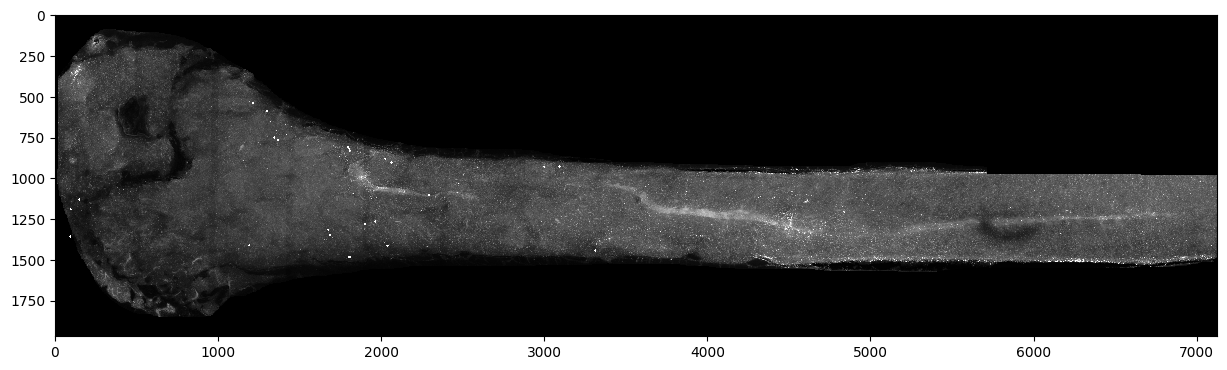

In [17]:
combined_tumor_image = cle.pull(masked_tumor.copy())

print(type(tumor_labels), tumor_labels.shape)
print(type(combined_tumor_image), combined_tumor_image.shape)

tumor_mask = tumor_labels != 0
if tumor_labels.shape == combined_tumor_image.shape:
    combined_tumor_image[tumor_mask] = tumor_labels[tumor_mask]
else:
    ValueError("arrays must have equal shape")

plt.figure(figsize=(15,15))
cle.imshow(combined_tumor_image)

In [18]:
del combined_tumor_image, original_tumor, masked_tumor

def dict_to_pointlist(tumor_dict: dict) -> np.ndarray:
    pointlist = np.zeros((3, len(tumor_dict)))
    for idx, tumor_info in tumor_dict.items():
        x_um, y_um, z_slice = map(int, (tumor_info["x (um)"], tumor_info["y (um)"], tumor_info["z (slice)"]))
        x, y, z = map(int, (x_um / x_step, y_um / y_step, z_slice-1))
        
        pointlist[0][idx] = x
        pointlist[1][idx] = y
        pointlist[2][idx] = z
        
    return pointlist

In [19]:
tumor_pointlist = dict_to_pointlist(tumor_dict)
print(tumor_pointlist)


[[  93.  148.   95. 1803. 2062. 2024. 1806. 1796. 2289. 1804. 2037. 1962.
  1675. 1899. 1683. 3091. 2998. 3310. 1214. 1297. 1343. 1366. 1190.]
 [1360. 1134. 1194.  823.  908.  884.  834.  811. 1107. 1485. 1417. 1267.
  1318. 1285. 1351.  931.  933. 1446.  544.  592.  755.  768. 1414.]
 [  54.   12.   29.   62.   61.   42.   39.   36.   47.    7.   20.   29.
    74.   75.   71.   11.   70.   58.   76.   69.   69.   67.   40.]]


In [20]:
del tumor_labels

Vessel Segmentation
-----------------------------

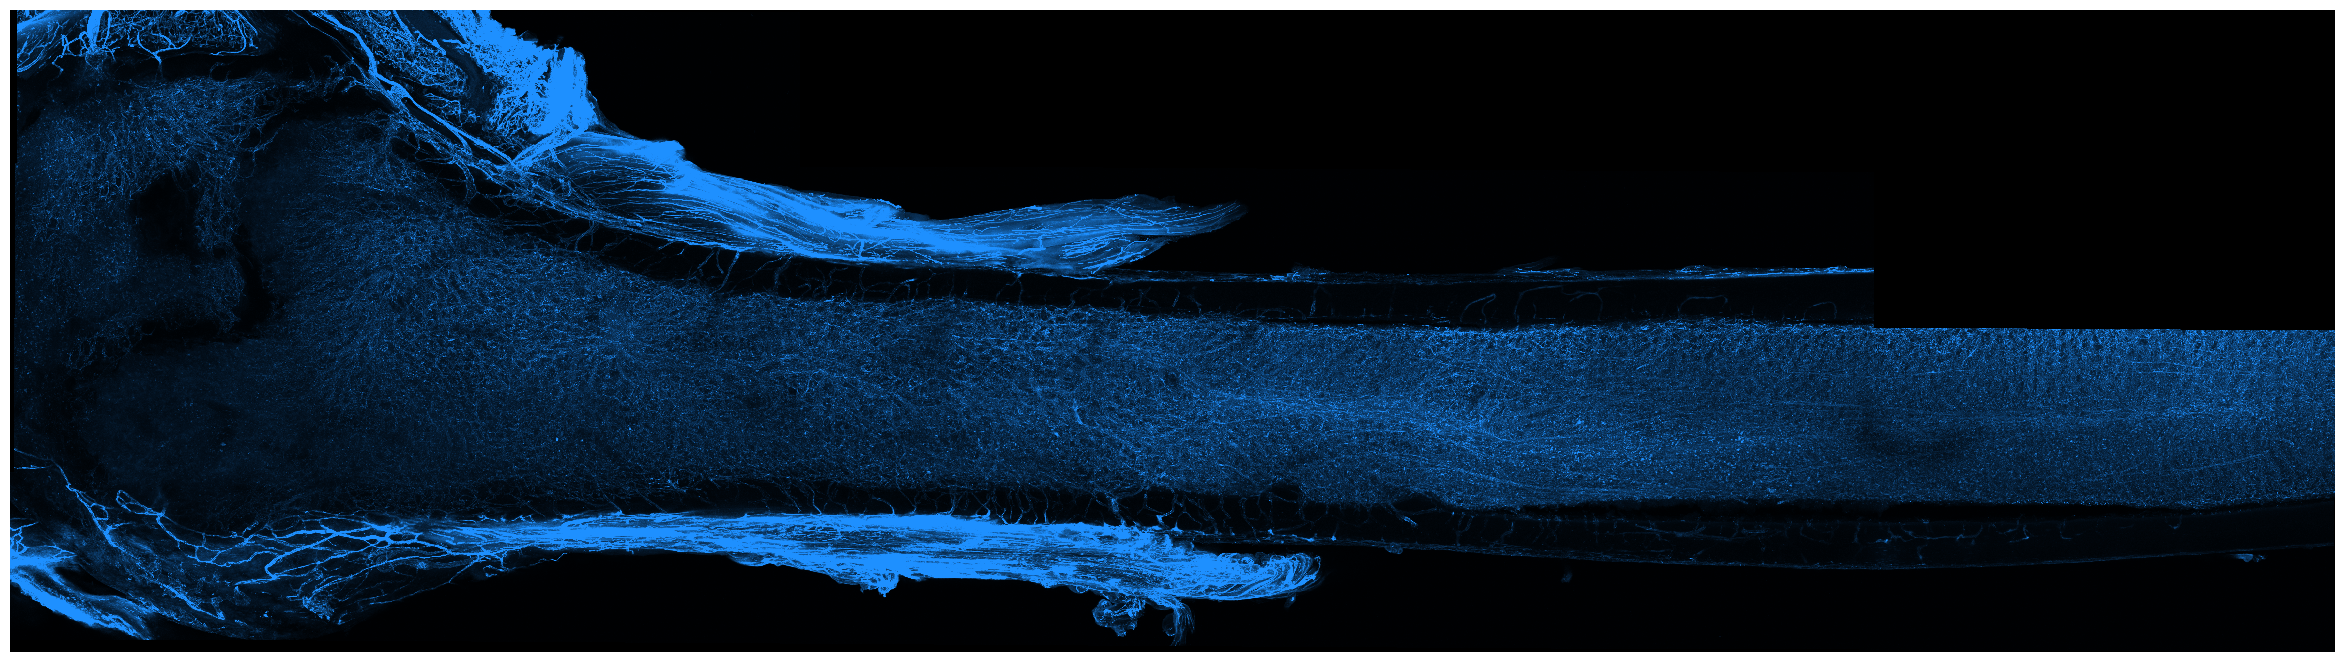

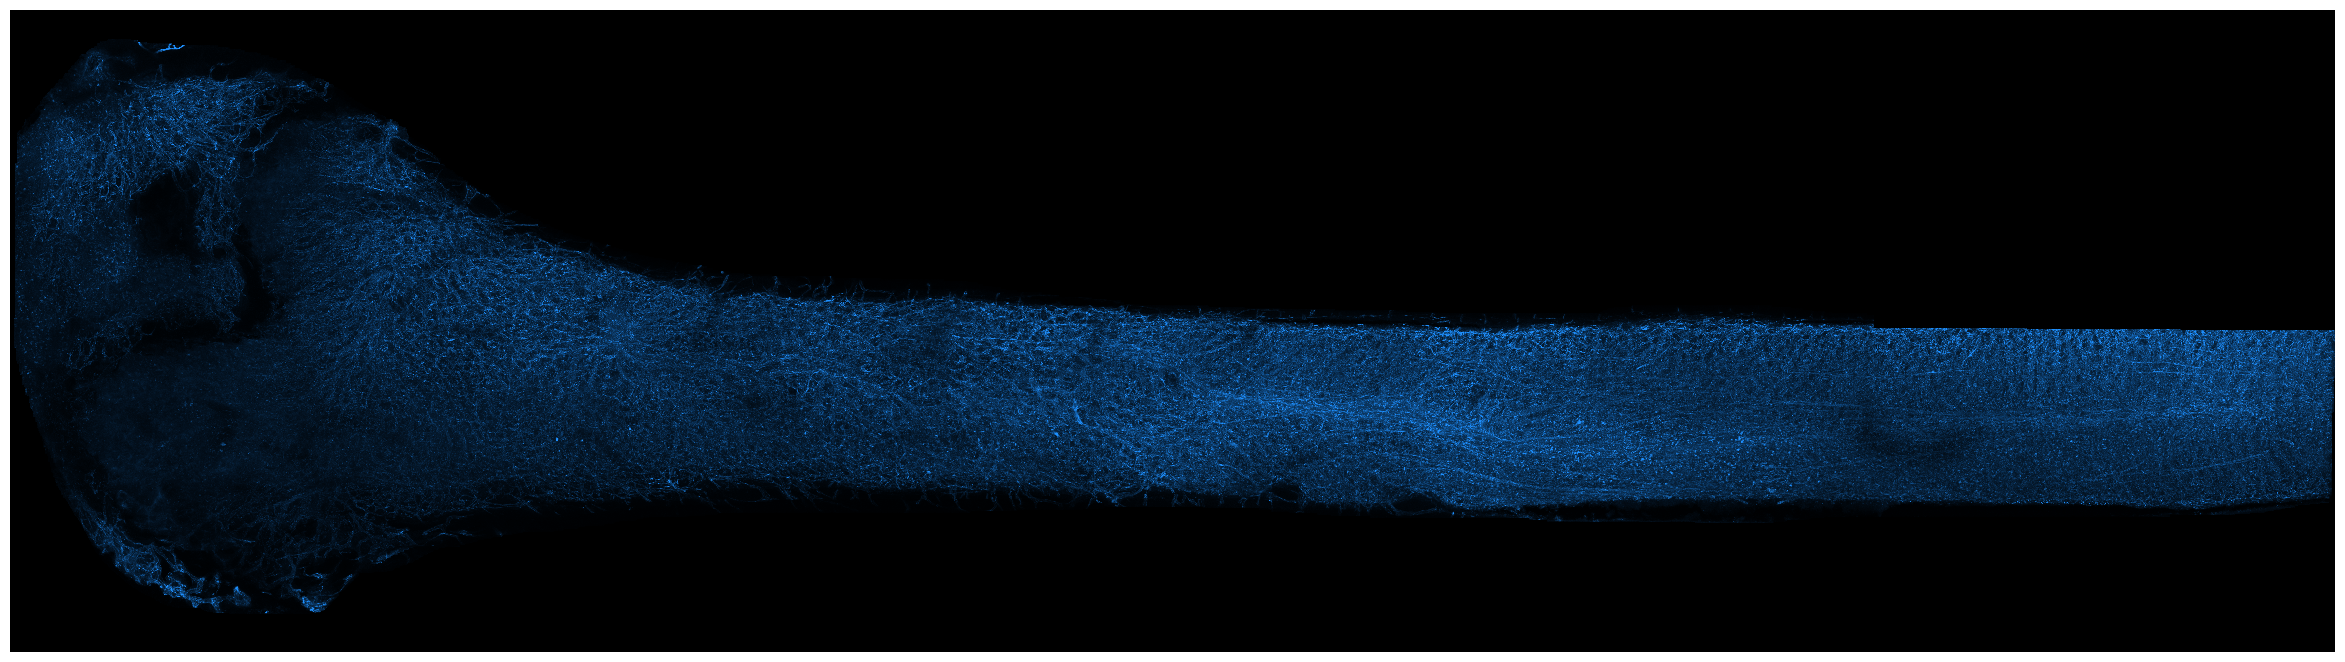

In [21]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "dodgerblue"])

original_vessels = cle.push(viewer.get_array()[2])
plt.figure(figsize=(30,15))
plt.axis("off")
cle.imshow(original_vessels, colormap=cmap)

masked_vessels = cle.mask(original_vessels, mask)
plt.figure(figsize=(30,15))
plt.axis("off")
cle.imshow(masked_vessels, colormap=cmap)

del original_vessels 

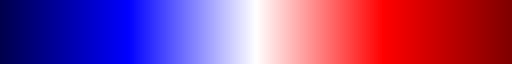

In [22]:
matplotlib.colormaps["seismic"]

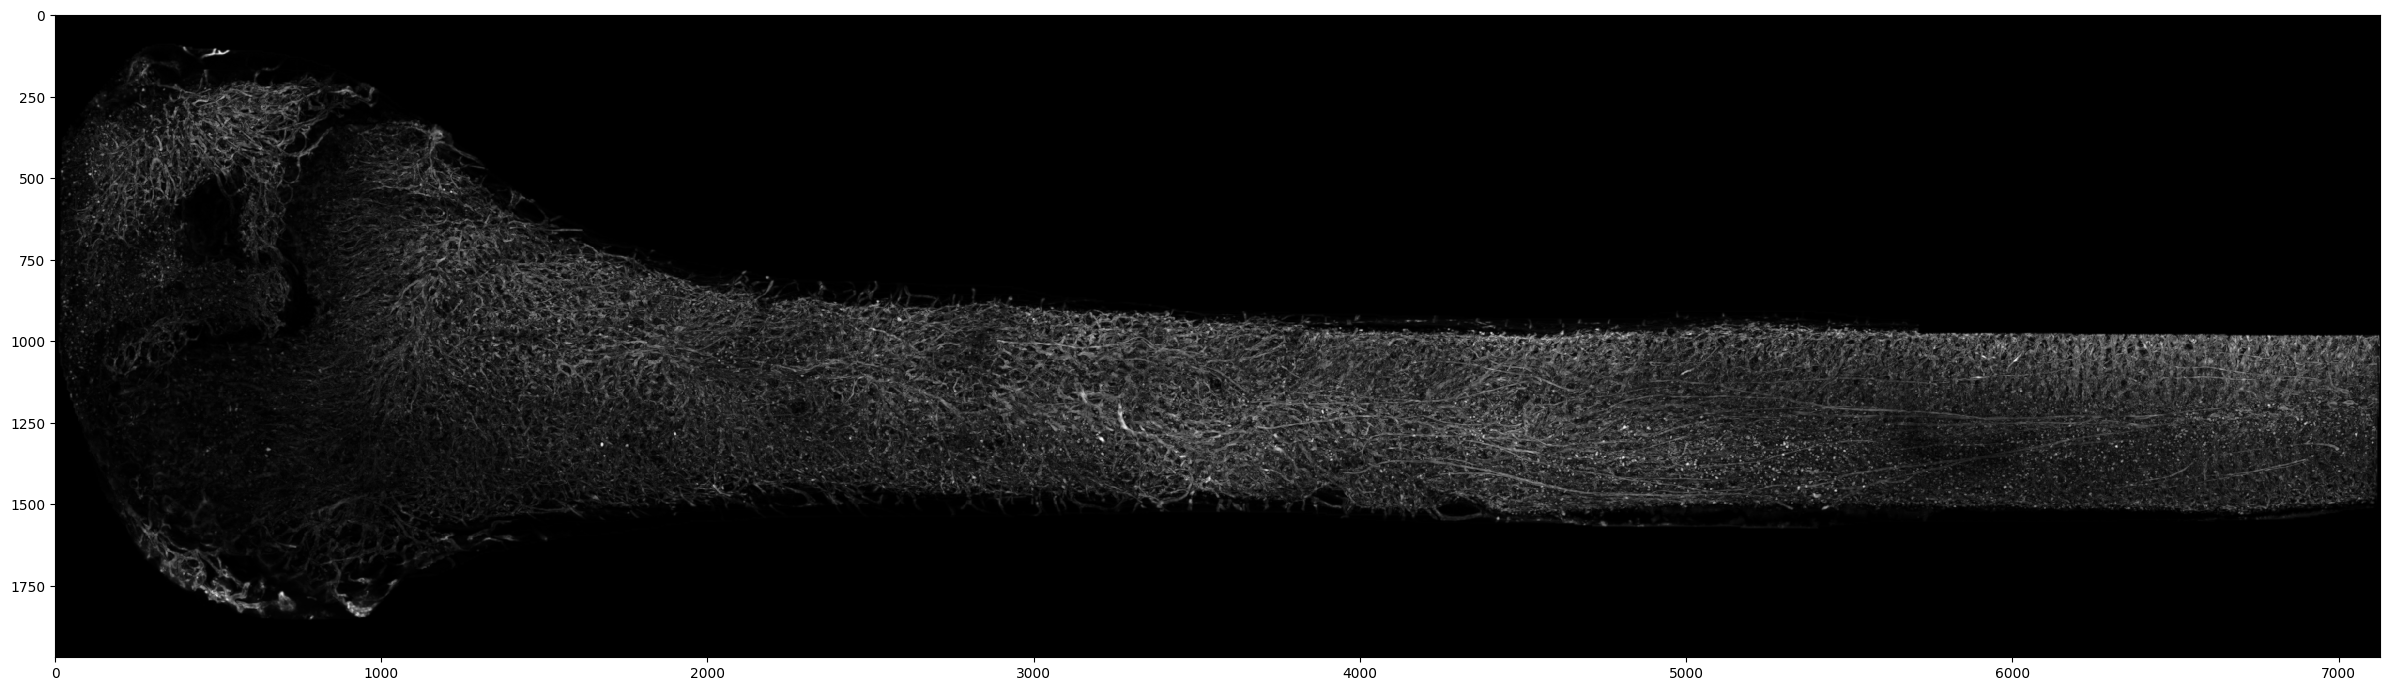

In [23]:
img_gaussian = cle.gaussian_blur(masked_vessels, sigma_x=2, sigma_y=2, sigma_z=2)

del masked_vessels

backgrund_subtracted = cle.top_hat_box(img_gaussian, radius_x=10, radius_y=10, radius_z=5)

plt.figure(figsize=(30,15))
cle.imshow(backgrund_subtracted)

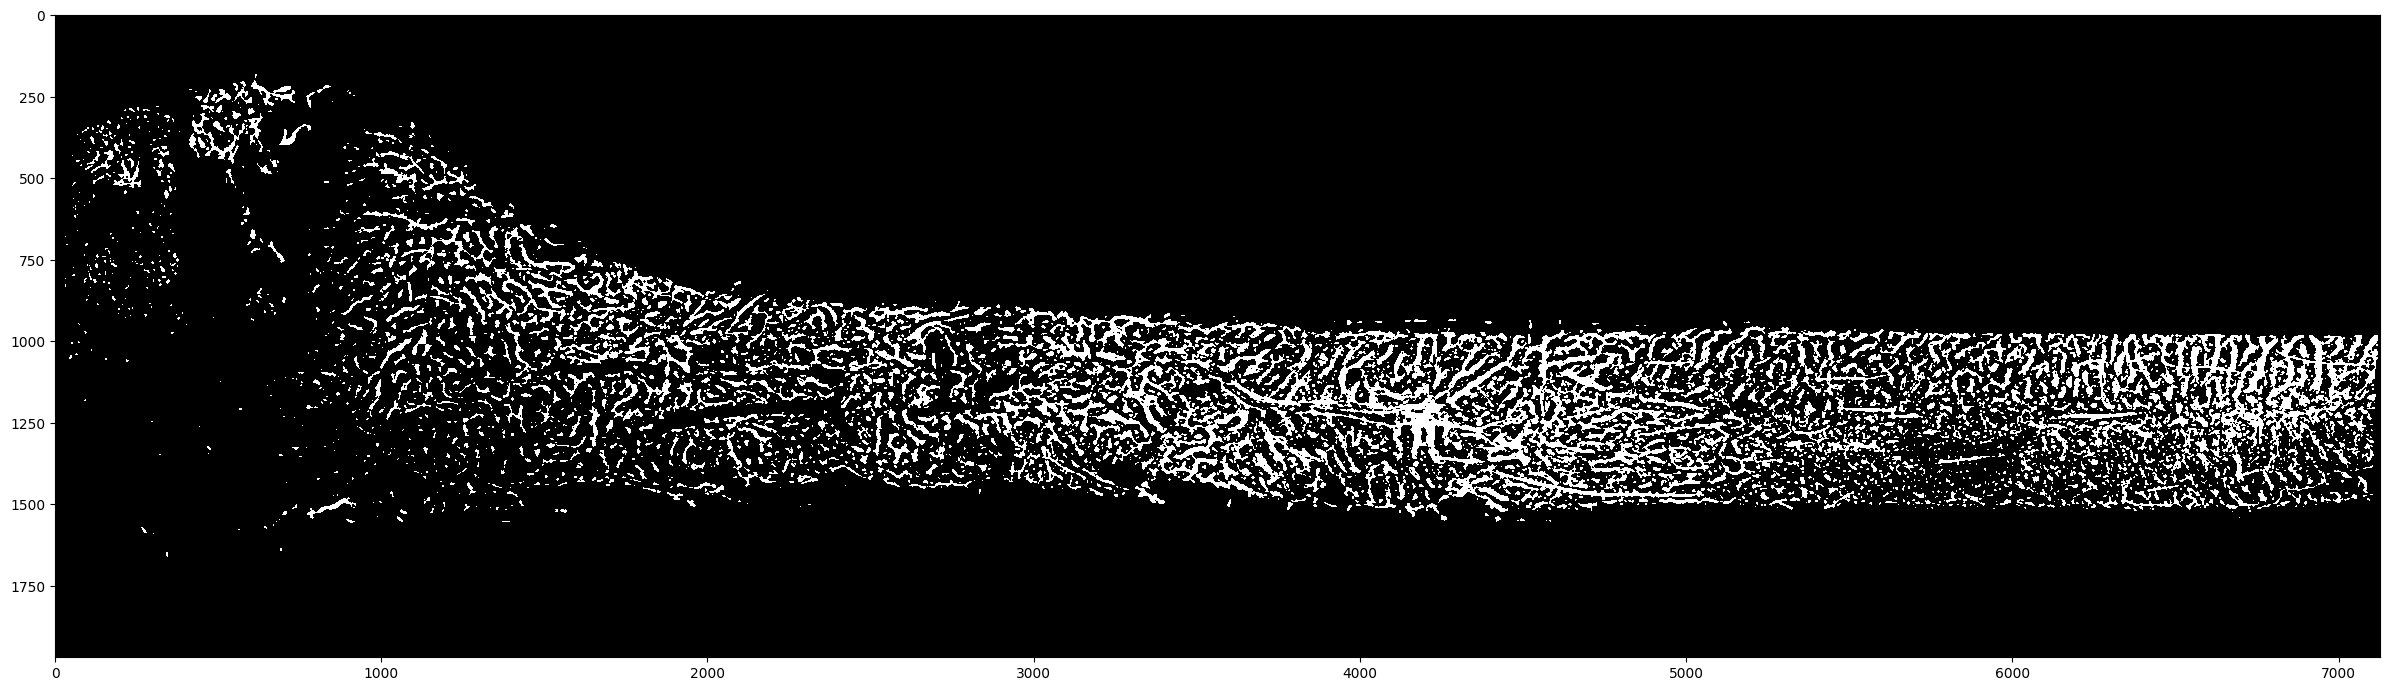

In [24]:
thresh2 = cle.threshold_otsu(backgrund_subtracted)

plt.figure(figsize=(30,15))
cle.imshow(thresh2[40])

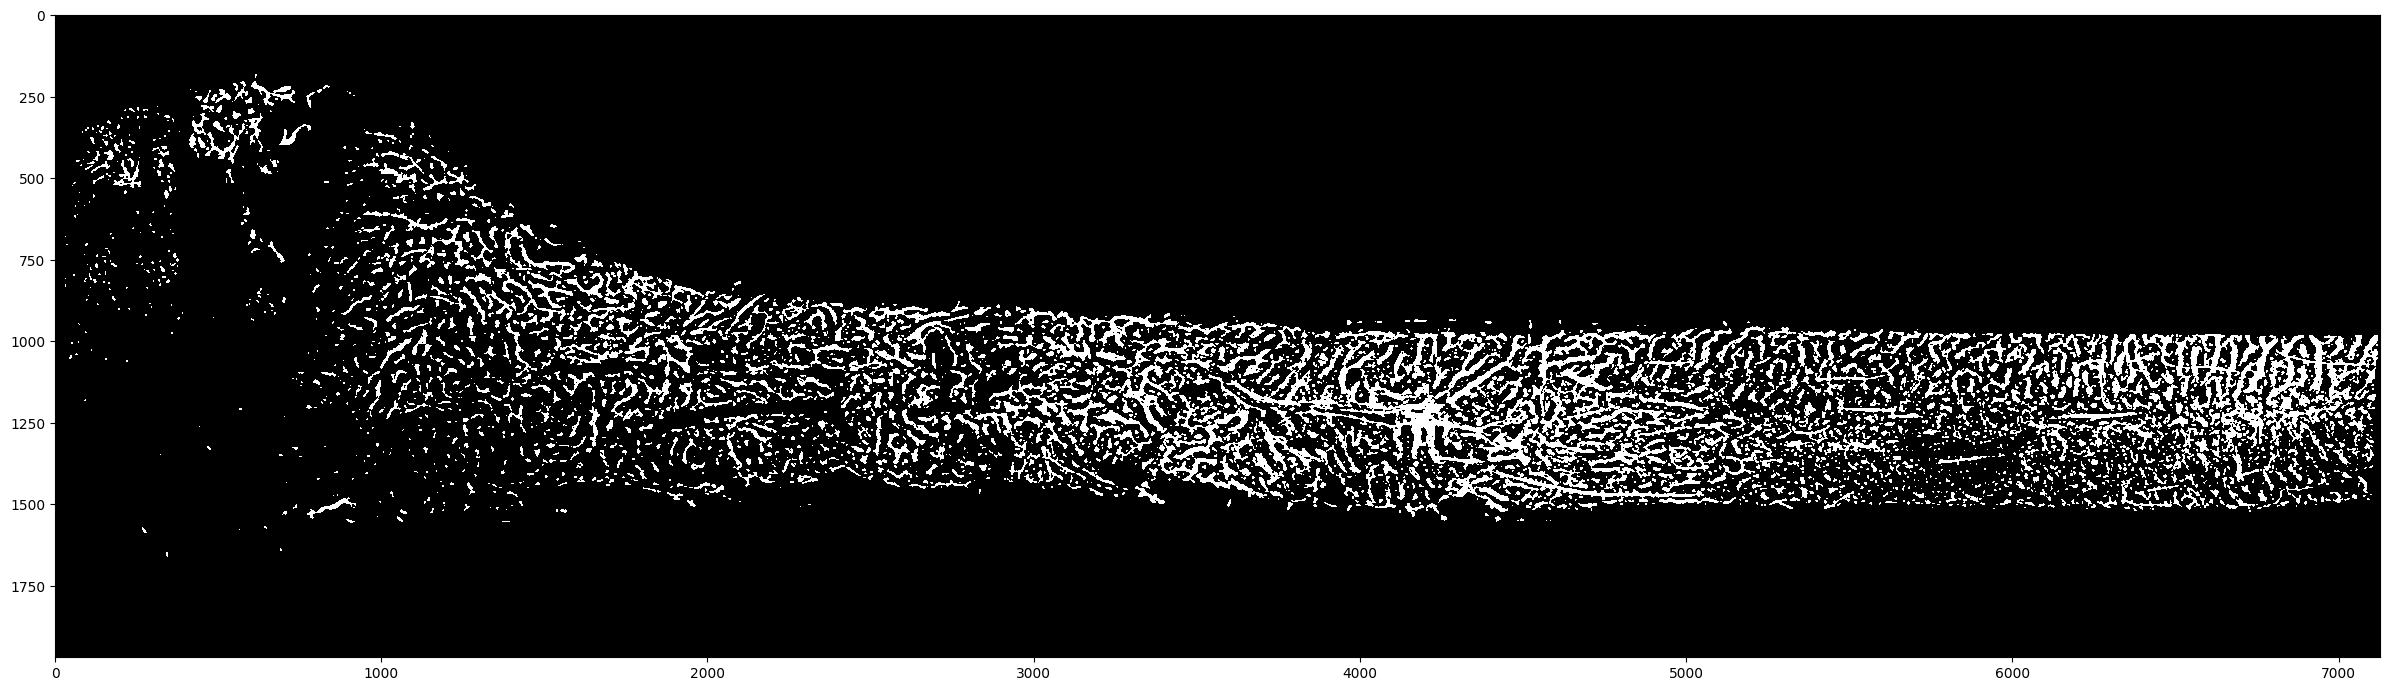

In [25]:
# Morphological openning
erosion = cle.erode_box(thresh2)
dilation = cle.dilate_box(erosion)

plt.figure(figsize=(30,15))
cle.imshow(dilation[40])

In [26]:
del erosion, img_gaussian, backgrund_subtracted, thresh2

In [27]:
# Convert dilation from uint8 to uint16
dilation = dilation.astype(np.uint16)
dilation *= 2**10 - 1 #2**16 - 1

# Add vessel segmentation result to total_image
# total_image = np.concatenate((total_image, np.expand_dims(cle.pull(dilation), axis=0)), axis=0)
# print(total_image.shape)
# print(total_image.dtype)

Find Vessel Bifurcations
----

In [28]:
def get_unique_orientations(cube):
    """
    List all possible unique variations of the given 3d array involving both rotation and reflection
    Inspired by @Colonel Panic at https://stackoverflow.com/questions/33190042/how-to-calculate-all-24-rotations-of-3d-array
    """
    if np.unique(cube, return_counts=True)[1][1] < 4:
        print("WARNING: <4 1s found within kernel. 4 is needed to detect branches. Ignore if using 2 for finding tips")

    variations = []

    def rotations4(cube, axes):
        """List the four rotations of the given 3d array in the plane spanned by the given axes."""
        for i in range(4):
            variations.append(np.rot90(cube, i, axes))

    for arr in [cube, np.flip(cube, axis=0), np.flip(cube, axis=1), np.flip(cube, axis=2)]:
    # for arr in [cube]:
        # imagine shape is pointing in axis 0 (up)
        # 4 rotations about axis 0
        rotations4(arr, (1,2))

        # rotate 180 about axis 1, now shape is pointing down in axis 0
        # 4 rotations about axis 0
        rotations4(np.rot90(arr, 2, axes=(0,2)), (1,2))

        # rotate 90 or 270 about axis 1, now shape is pointing in axis 2
        # 8 rotations about axis 2
        rotations4(np.rot90(arr, 1, axes=(0,2)), (0,1))
        rotations4(np.rot90(arr, -1, axes=(0,2)), (0,1))

        # rotate about axis 2, now shape is pointing in axis 1
        # 8 rotations about axis 1
        rotations4(np.rot90(arr, 1, axes=(0,1)), (0,2))
        rotations4(np.rot90(arr, -1, axes=(0,1)), (0,2))

    return np.unique(variations, axis=0)

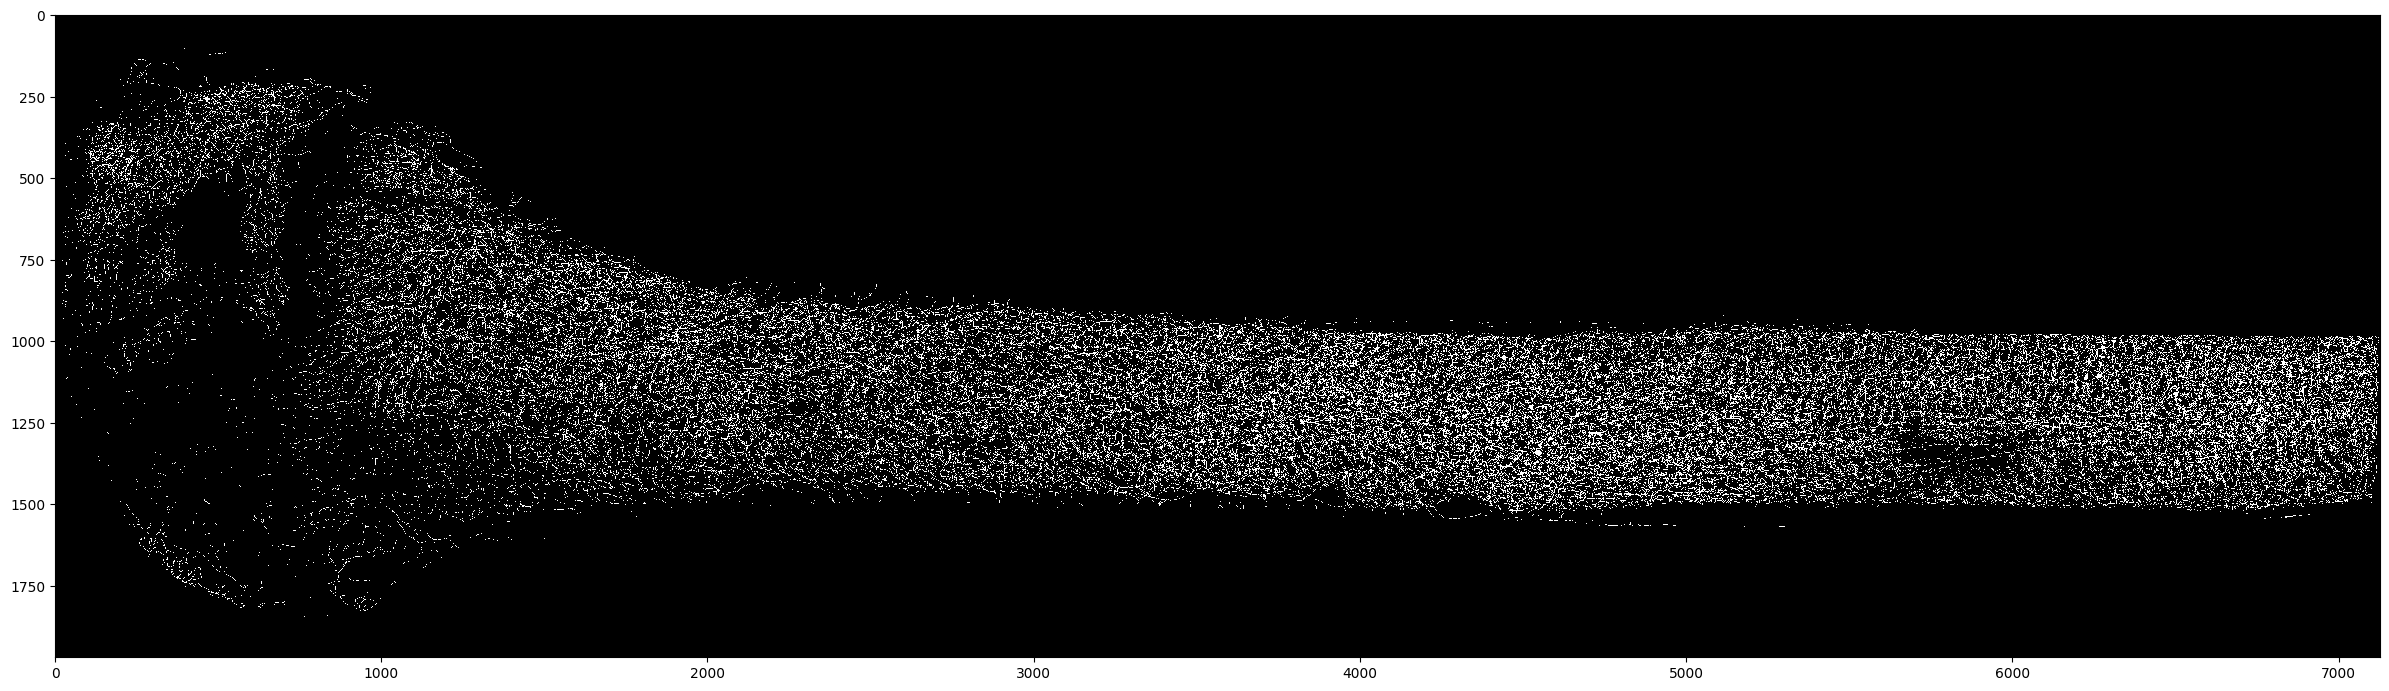

In [29]:
from skimage.morphology import skeletonize_3d
skeleton = skeletonize_3d(dilation)

plt.figure(figsize=(30,15))
cle.imshow(skeleton)

In [30]:
# total_image = np.concatenate((total_image, np.expand_dims(cle.pull(skeleton), axis=0)), axis=0)
del dilation

In [31]:
kernel_cache_path = os.path.join(LIBPATH, "unique_kernels.npy")
if os.path.exists(kernel_cache_path):
    # Load unique kernels from cache
    print("Unique kernel cache found! Loading...")
    kernels = load_from_cache(kernel_cache_path)
    print(f"{len(kernels)} kernels loaded!")
else:
    # Get unique kernels
    print("Kernel cache not found! Generating...")
    kernels = get_unique_kernels()


Unique kernel cache found! Loading...
4670 kernels loaded!


100%|███████████████████████████████████████| 4670/4670 [07:42<00:00, 10.09it/s]


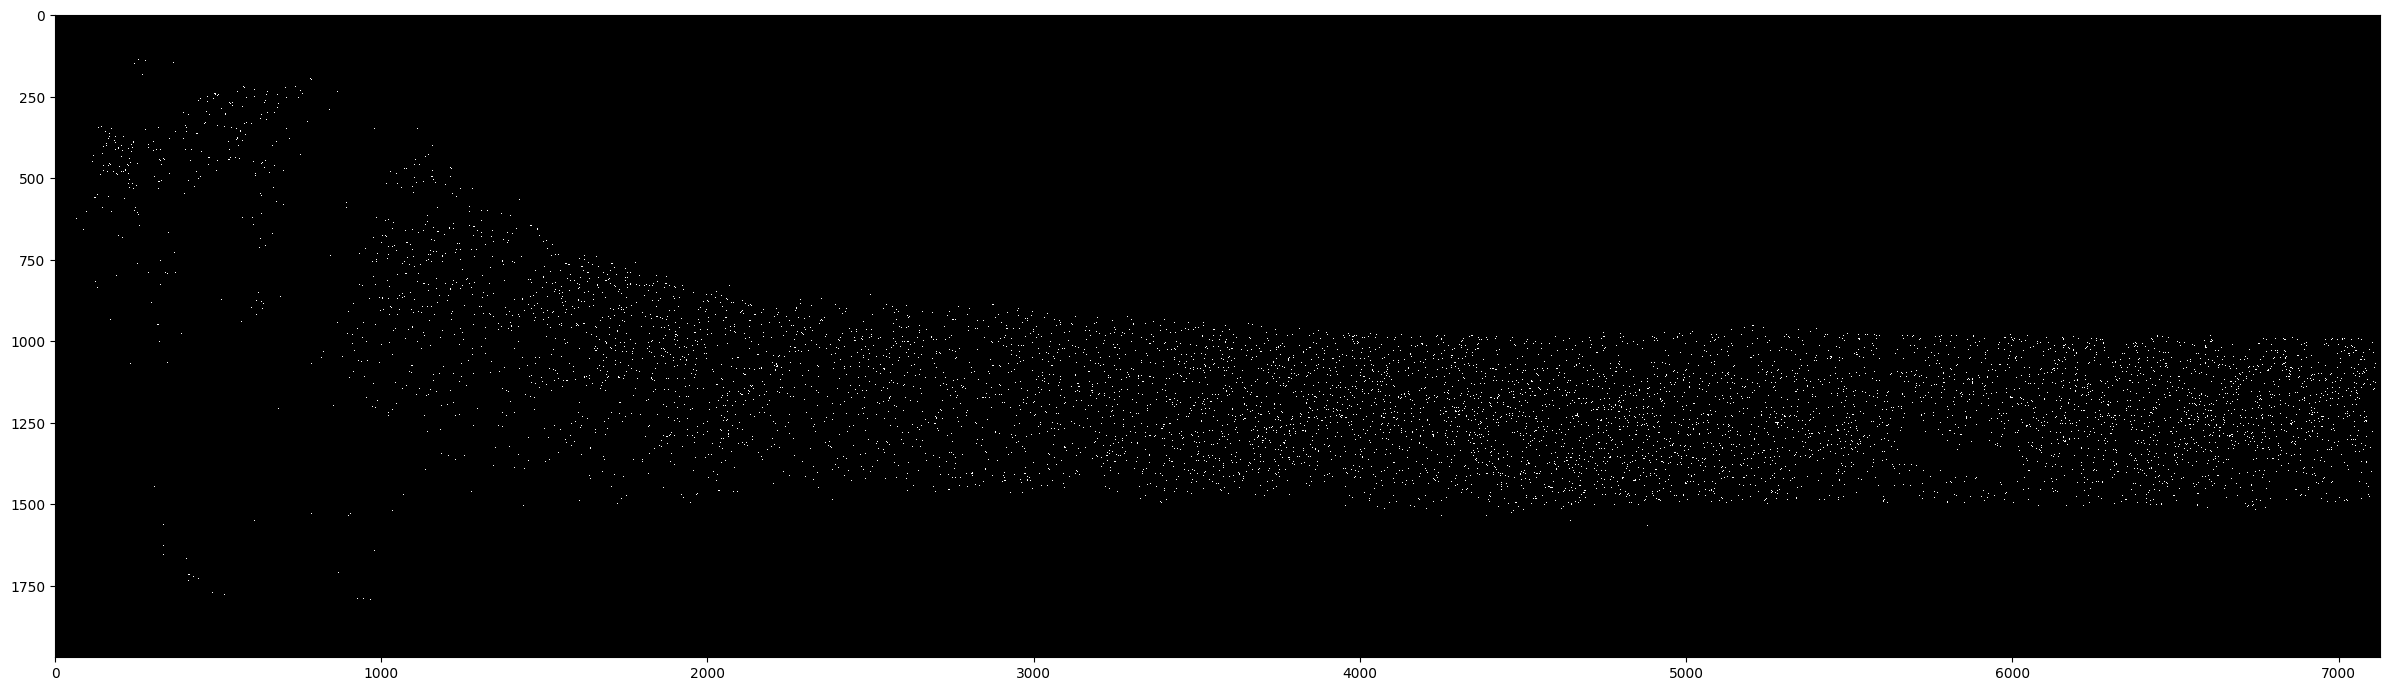

In [32]:
branch_pts_img = cp.zeros(skeleton.shape, dtype=int)
cp_skeleton = cp.asarray(skeleton)
for kernel in tqdm(kernels):
    branch_pts_img = cp.logical_or(
        binary_hit_or_miss(cp_skeleton, structure1=cp.asarray(kernel)),
        branch_pts_img,
    )
branch_pts_img = cp.asnumpy(branch_pts_img.astype(np.uint8) * 255)

plt.figure(figsize=(30,20))
cle.imshow(branch_pts_img)

# print(total_image.shape)
# total_image = np.concatenate((total_image, np.expand_dims(branch_pts_img, axis=0)), axis=0)
# print(total_image.shape)

In [33]:
# 24411 old
branch_points = np.nonzero(branch_pts_img)
print(branch_pts_img.shape)
print(branch_points)

(77, 1969, 7127)
(array([ 0,  0,  0, ..., 76, 76, 76]), array([ 537,  603,  619, ..., 1002, 1383, 1385]), array([ 676,  977, 1062, ..., 4510, 4766, 4764]))


In [34]:
print(len(branch_points[0]))

67596


In [35]:
# np.save(os.path.join(ROOTPATH, f"branch_points/{filename}_branch_points.npy", np.array(branch_points)))

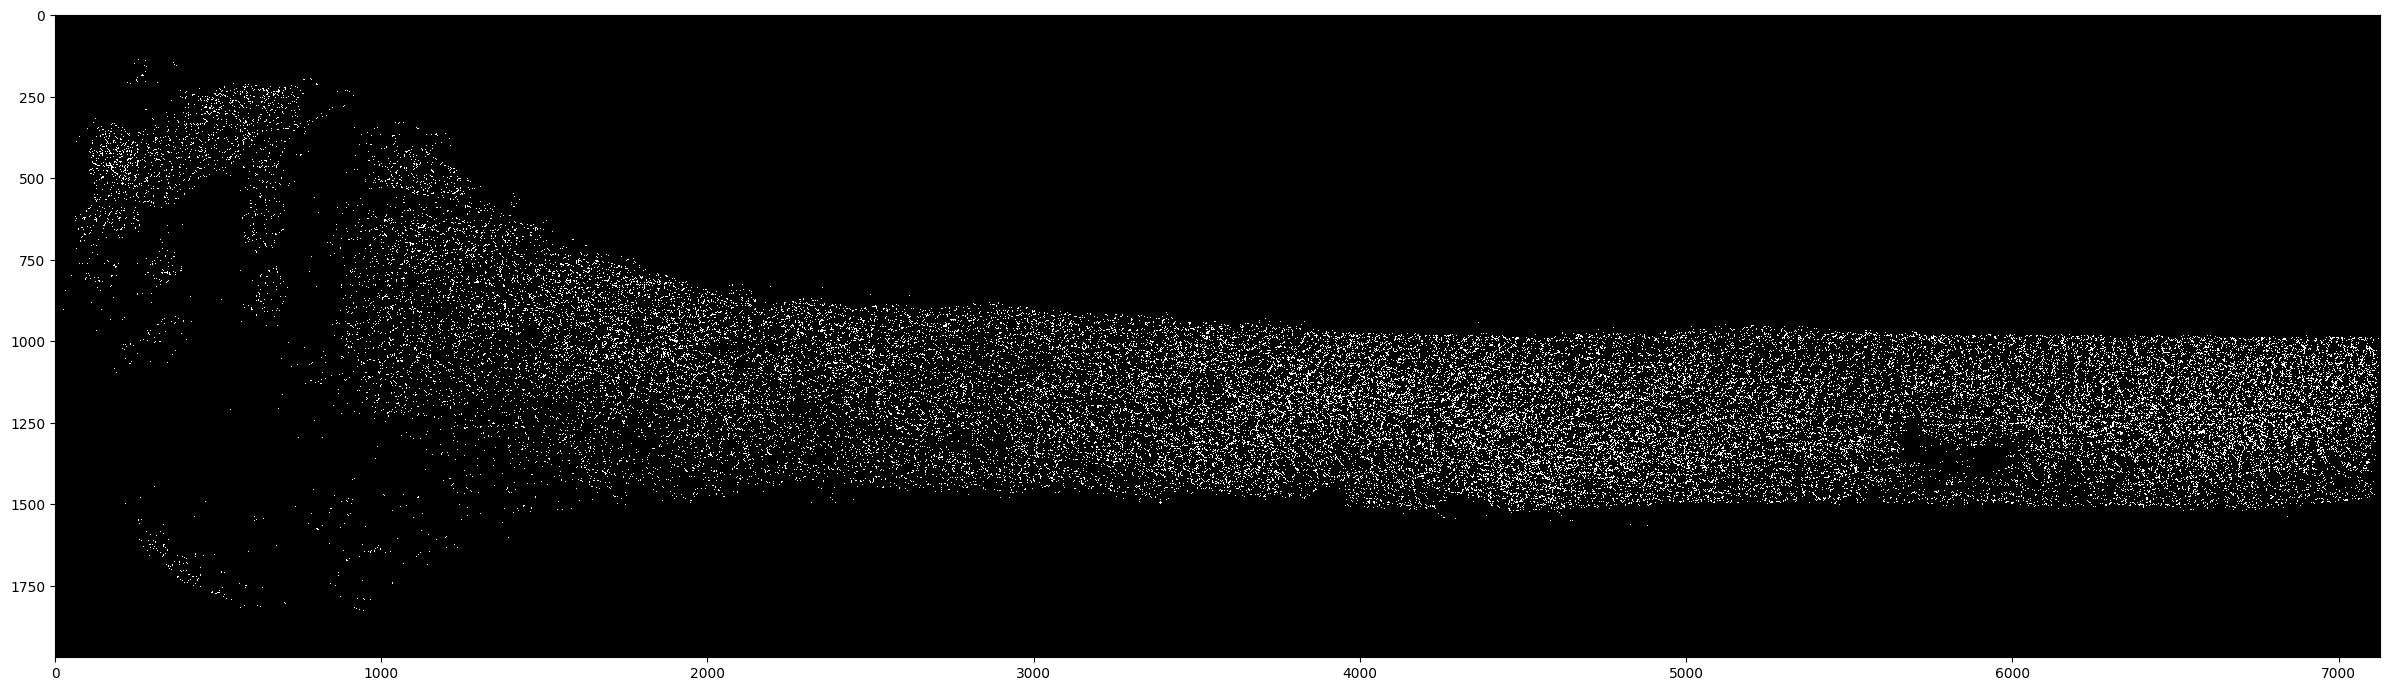

In [36]:
dilated_branch_pts_img = cle.dilate_box(branch_pts_img)

plt.figure(figsize=(30,20))
cle.imshow(dilated_branch_pts_img)

In [37]:
subtracted_pts = cle.binary_subtract(skeleton, dilated_branch_pts_img)
# vessel_segments = cle.connected_components_labeling_box(subtracted_pts)

In [38]:
del branch_pts_img, dilated_branch_pts_img, cp_skeleton, skeleton

63146


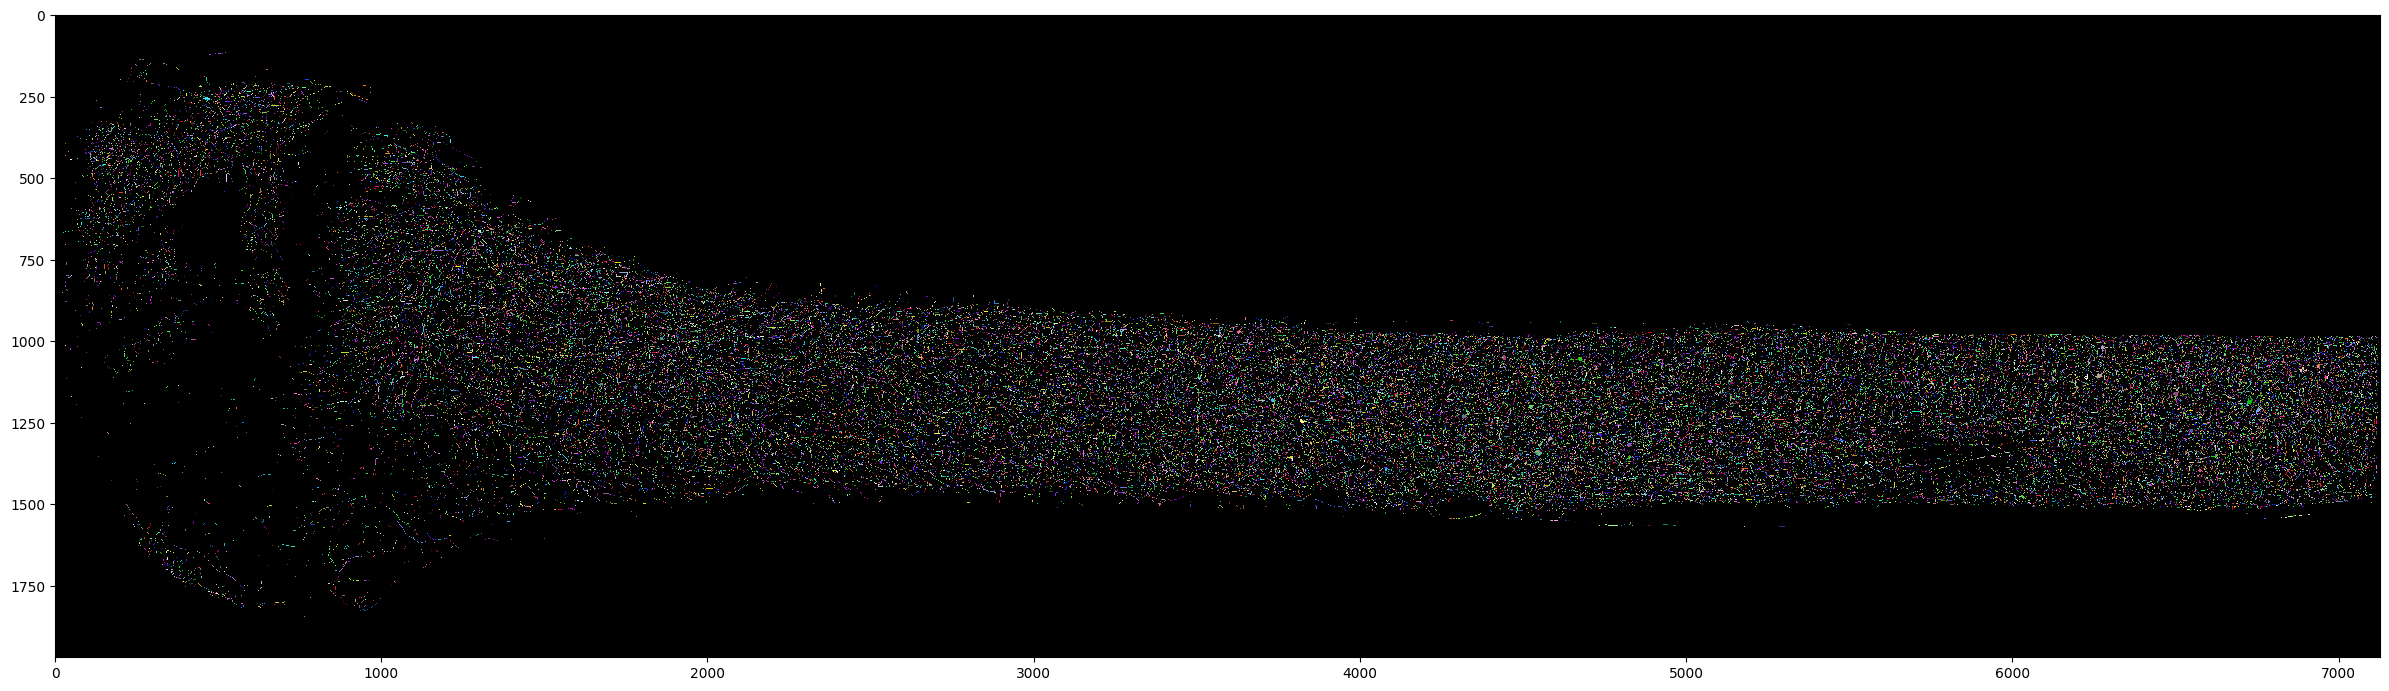

In [39]:
import cc3d

# Removes segments less than 5 pixels long
subtracted_pts = cc3d.dust(cle.pull(subtracted_pts), threshold=5, in_place=False)
vessel_segments2, N = cc3d.connected_components(subtracted_pts, return_N=True)
print(N)

fig1 = plt.figure(figsize=(30,20))
cle.imshow(vessel_segments2, labels=True)
# fig1.savefig("segmented_vessel_segments.png", dpi=1000)

In [40]:
tip_kernels = []

# Filter 1
tip_kernels.append(np.array([[[0, 0, 0],
                              [0, 0, 0],
                              [0, 0, 0]
                             ],
                             [[0, 0, 1],
                              [0, 1, 0],
                              [0, 0, 0]
                             ],
                             [[0, 0, 0],
                              [0, 0, 0],
                              [0, 0, 0]]]))

# Filter 2
tip_kernels.append(np.array([[[0, 0, 0],
                              [0, 0, 0],
                              [0, 0, 0]
                             ],
                             [[0, 1, 0],
                              [0, 1, 0],
                              [0, 0, 0]
                             ],
                             [[0, 0, 0],
                              [0, 0, 0],
                              [0, 0, 0]]]))

# Filter 3
tip_kernels.append(np.array([[[0, 0, 1],
                              [0, 0, 0],
                              [0, 0, 0]
                             ],
                             [[0, 0, 0],
                              [0, 1, 0],
                              [0, 0, 0]
                             ],
                             [[0, 0, 0],
                              [0, 0, 0],
                              [0, 0, 0]]]))

unique_tip_kernels = []
for kernel in tip_kernels:
    unique_tip_kernels.extend(get_unique_orientations(kernel))

In [41]:
a = cp.array([])

print(type(a))
print(isinstance(a, cp.ndarray))

<class 'cupy.ndarray'>
True


In [42]:
def trim_zeros(arr):
    """Returns a trimmed view of an n-D array excluding any outer
    regions which contain only zeros.
    """
    if isinstance(arr, cp.ndarray):
        nonzero = cp.nonzero
    elif isinstance(arr, np.ndarray):
        nonzero = np.nonzero
    else:
        raise ValueError("arr needs to be np or cp ndarray type")

    slices = tuple(slice(idx.min(), idx.max() + 1) for idx in nonzero(arr))
    return arr[slices]

def euclidean_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.

    Args:
    point1 (array-like): An array-like object representing the first point.
    point2 (array-like): An array-like object representing the second point.

    Returns:
    float: The Euclidean distance between the two points.
    """
    # Use NumPy's linalg.norm function to calculate the Euclidean distance
    return np.linalg.norm(np.array(point1)-np.array(point2))

In [43]:
import dijkstra3d

# Remove 0 from list
vessel_segments = cp.asarray(vessel_segments2)
segment_labels = cp.unique(vessel_segments)[1:]

tortuosity_lib = {}
for label in tqdm(segment_labels):
    segment = cp.where(vessel_segments==int(label), True, False)
    cropped_segment = trim_zeros(segment)

    tips_img = cp.zeros(cropped_segment.shape, dtype=int)
    for kernel in unique_tip_kernels:
        kernel = cp.asarray(kernel)
        tips_img = cp.logical_or(binary_hit_or_miss(cropped_segment, structure1=kernel), tips_img)
    tips_img = cp.asnumpy(tips_img.astype(np.uint8) * 255)
    n_tips = tips_img.sum() / 255

    # Check that there are only 2 tips found. 
    if n_tips == 2:
        start_pt = [i[0] for i in np.nonzero(tips_img)]
        end_pt = [i[1] for i in np.nonzero(tips_img)]

    # More than 2 tips indicates that a branching point was not identified and subtracted properly.
    elif n_tips > 2:
        # print(f"Error with label: {label}")
        # print(cropped_segment.shape)
        cropped_segment = cp.asnumpy(cropped_segment)
        z, y, x = np.nonzero(tips_img)

        paths = []
        for tip_a, tip_b in itertools.combinations(zip(z, y, x), 2):
            path = dijkstra3d.binary_dijkstra(cropped_segment, source=tip_a, target=tip_b)
            paths.append((tip_a, tip_b, path))
        
        start_pt, end_pt, longest_path = sorted(paths, key=lambda x: x[2].shape[0], reverse=True)[0]
        cropped_segment = np.zeros(cropped_segment.shape, dtype=int)
        cropped_segment[tuple(longest_path.T)] = 1

    # Less than 2 tips means this is an unrecoverable segment. Set tortuosity to 0 so it is removed in the next step
    # and skip
    else:
        print(f"Skipping abnormal segment #{int(label)}...")
        tortuosity_lib[int(label)] = 0
        continue

    euclid_dist = euclidean_distance(start_pt, end_pt)
    geodesic_dist = cropped_segment.sum()
    tortuosity = 1. * geodesic_dist / euclid_dist

    # tortuosity_lib[int(label)] = min(float(tortuosity), 3.)
    tortuosity_lib[int(label)] = float(tortuosity)

print("Finished calculating tortuosity for each segment")
print("Now replacing label with tortuosity value in full image")


 21%|███████▊                             | 13281/63146 [11:18<42:56, 19.36it/s]

Skipping abnormal segment #13278...


 37%|█████████████▌                       | 23125/63146 [19:41<34:02, 19.59it/s]

Skipping abnormal segment #23122...


 41%|███████████████                      | 25603/63146 [21:48<31:56, 19.59it/s]

Skipping abnormal segment #25601...


 58%|█████████████████████▍               | 36673/63146 [31:13<22:30, 19.60it/s]

Skipping abnormal segment #36671...


 65%|████████████████████████             | 41055/63146 [34:57<18:50, 19.55it/s]

Skipping abnormal segment #41053...


 73%|███████████████████████████▏         | 46293/63146 [39:25<14:19, 19.60it/s]

Skipping abnormal segment #46291...


 74%|███████████████████████████▎         | 46535/63146 [39:37<14:07, 19.60it/s]

Skipping abnormal segment #46533...


 77%|████████████████████████████▍        | 48541/63146 [41:20<12:26, 19.56it/s]

Skipping abnormal segment #48538...


 89%|████████████████████████████████▊    | 56039/63146 [47:43<06:03, 19.57it/s]

Skipping abnormal segment #56037...


 94%|██████████████████████████████████▊  | 59415/63146 [50:35<03:10, 19.63it/s]

Skipping abnormal segment #59412...


 98%|████████████████████████████████████▏| 61797/63146 [52:37<01:09, 19.54it/s]

Skipping abnormal segment #61795...


100%|█████████████████████████████████████| 63146/63146 [53:46<00:00, 19.57it/s]

Finished calculating tortuosity for each segment
Now replacing label with tortuosity value in full image


In [44]:
# Removes zeros (0)
tortuosity_lib = {k: v for k, v in tortuosity_lib.items() if v > 0}

# sorted(tortuosity_lib.items(), key=lambda x: x[1], reverse=False)


Tortuosity Mean: 1.0373 +/- 0.1693
Tortuosity Threshold set to 1.375868930560066
0.649519052838329 7.424621202458749


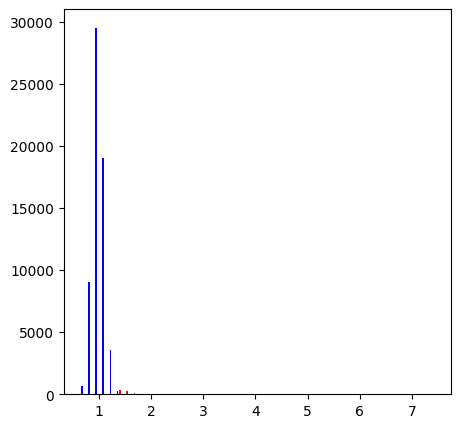

In [45]:
def normalize(x, min, max):
    return (x - min) / (max - min)

def replace_np_values(arr: np.ndarray, map: dict) -> np.ndarray:
    fn = np.vectorize(lambda x: map.get(x, 0) * 255)
    return fn(arr)

# Remove top n from dictionary
n = 25
sorted_t_items = sorted(tortuosity_lib.items(), reverse=True, key=lambda x: x[1])
t_key = {k: v for i, (k, v) in enumerate(sorted_t_items) if i > n}

t_values = np.array(list(t_key.values()))
t_std = np.std(t_values)
t_mean = np.mean(t_values)
print(f"Tortuosity Mean: {t_mean:.4f} +/- {t_std:.4f}")

t_threshold = t_mean + 2*t_std
print(f"Tortuosity Threshold set to {t_threshold}")

plt.figure(figsize=(5,5))

idx = t_values > t_threshold
plt.hist([t_values[~idx], t_values[idx]], color=["b", "r"], bins=50, width=0.03)

t_min, t_max = np.min(t_values), np.max(t_values)
print(t_min, t_max)

In [46]:
# del vessel_segments2
del subtracted_pts

In [47]:
del segment

In [48]:
# cle.pull(cle.centroids_of_labels(cle.push(vessel_segments)))

In [49]:
normalized_map = {k: normalize(v, t_min, t_max) for k, v in t_key.items()}
result_array = replace_np_values(cp.asnumpy(vessel_segments), normalized_map)


In [50]:
print(np.unique(result_array, return_counts=True))

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  72,  73,  74,  75,  76,  77,  79,
        80,  82,  83,  84,  85,  86,  87,  89,  93,  94,  96,  97,  99,
       100, 101, 102, 104, 105, 106, 113, 118, 120, 122, 125, 129, 131,
       134, 135, 136, 142, 149, 152, 155, 161, 167, 173, 177, 180, 182,
       186, 188, 196, 201, 206, 211, 212, 215, 220, 231, 237, 254, 255]), array([1079747753,        151,        542,       1215,       3006,
             6130,       9564,      19949,      25084,      38994,
            49455,      53750,      74838,      98442,     104182,
            80798,      62693,      38890,      26186,      25466,
         

In [51]:
cmap = matplotlib.cm.get_cmap("inferno", 5)

fig1 = plt.figure(figsize=(25,15))
cle.imshow(result_array, colorbar=True, color_map=cmap)
# fig1.savefig("tortuosity_heatmap.png", dpi=1000)

/tmp/ipykernel_1714405/3537598779.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("inferno", 5)


MemoryError: clEnqueueWriteBuffer failed: MEM_OBJECT_ALLOCATION_FAILURE

<Figure size 2500x1500 with 0 Axes>

In [ ]:
result_values = result_array[result_array>0].flatten()
result_std = np.std(result_values)
result_mean = np.mean(result_values)
print(f"Tortuosity Mean: {result_mean:.4f} +/- {result_std:.4f}")

result_threshold = result_mean + 3*result_std
print(f"Tortuosity Threshold set to {t_threshold}")

plt.figure(figsize=(5,5))

result_idx = result_values > result_threshold
plt.axvline(x=result_threshold, linestyle="dotted", linewidth=1.25, color="grey")
plt.hist([result_values[~result_idx], result_values[result_idx]], color=["b", "r"], bins=50, width=7)

result_min, result_max = np.min(result_values), np.max(result_values)
print(result_min, result_max)

In [ ]:
# plt.figure(figsize=(15,15))



# plt.boxplot(result_array[result_array>0].flatten())

In [ ]:
np.unique(result_array)

In [ ]:
bin_result_array = result_array.copy()
low_thresh_idx = np.where(np.logical_and(bin_result_array > 0,
                                         bin_result_array <= result_threshold))
high_thresh_idx = np.where(np.logical_and(bin_result_array > 0,
                                          bin_result_array > result_threshold))
bin_result_array[low_thresh_idx] = 55
bin_result_array[high_thresh_idx] = 255

print(np.unique(bin_result_array))
print(result_threshold)

In [ ]:

plt.figure(figsize=(25,15))
cle.imshow(cle.push(bin_result_array), colorbar=True, color_map="gist_stern")


In [ ]:
# extract centroids from high tortuosity segments as pointlist
bin_result_array[bin_result_array < 255] = 0
labeled_tortuous_segments = cle.connected_components_labeling_box(cle.push(bin_result_array))
tortuous_segments_pointlist = cle.centroids_of_labels(labeled_tortuous_segments)
print(tortuous_segments_pointlist)

In [ ]:
# np.save(os.path.join(ROOTPATH, f"tortuous_segment_centroids/{filename}_tortuous_segment_centroid.npy", np.array(tortuous_segments_pointlist)))
del bin_result_array

In [ ]:
# print(

In [ ]:
# ## Visualizing one segment

# one_segment = np.where(vessel_segments2 == 1199, 1, 0)
# # print(cle.statistics_of_labelled_pixels(skeleton, vessel_segments))
# print(one_segment.sum())

In [ ]:
# cropped_one_segment = trim_zeros(one_segment)
# print(cropped_one_segment.shape)
# # print(cropped_one_segment)
# plt.figure(figsize=(6,4))
# cle.imshow(cle.push(cropped_one_segment), labels=True)

In [ ]:
# tips_img = cp.zeros(cropped_one_segment.shape, dtype=int)
# for kernel in unique_tip_kernels:
#     kernel = cp.asarray(kernel)
#     tips_img = cp.logical_or(binary_hit_or_miss(cp.asarray(cropped_one_segment), structure1=kernel), tips_img)
# tips_img = cp.asnumpy(tips_img.astype(np.uint8) * 255)
# n_tips = tips_img.sum() / 255

# # Check that there are only 2 tips found. 
# if n_tips == 2:
#     start_pt = [i[0] for i in np.nonzero(tips_img)]
#     end_pt = [i[1] for i in np.nonzero(tips_img)]
#     print(euclidean_distance(start_pt, end_pt))
#     print(cropped_one_segment.sum())

In [ ]:
# print(start_pt)
# print(end_pt)

In [ ]:
# import napari
# viewer = napari.view_image(cropped_one_segment)

In [ ]:
# unique_tip_kernels = []

# for kernel in tip_kernels:
#     unique_tip_kernels.extend(get_unique_orientations(kernel))

In [ ]:
# tips_img = cp.zeros(cropped_one_segment.shape, dtype=int)

# for kernel in tqdm(unique_tip_kernels):
#     kernel = cp.asarray(kernel)
#     tips_img = cp.logical_or(binary_hit_or_miss(cp.asarray(cropped_one_segment), structure1=kernel),
#                                    tips_img)
# tips_img = cp.asnumpy(tips_img.astype(np.uint8) * 255)

# # assert tips_img.sum()/255 == 2

# start_pt = [i[0] for i in np.nonzero(tips_img)]
# end_pt = [i[1] for i in np.nonzero(tips_img)]

# euclid_dist = euclidean_distance(start_pt, end_pt)
# geodesic_dist = cropped_one_segment.sum()

# print(f"Geodesic distance: {geodesic_dist}")
# print(f"Euclidean distance: {euclid_dist}")
# print(f"Tortuosity: {geodesic_dist / euclid_dist}")

# plt.figure(figsize=(30,20))
# cle.imshow(tips_img)

In [ ]:
# del skeleton, branch_pts_img

NG2 Segmentation
---------------------------

In [ ]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red"])

original_ng2 = cle.push(viewer.get_array()[1])
plt.figure(figsize=(30,15))
cle.imshow(original_ng2, colormap=cmap)

masked_ng2 = cle.mask(original_ng2, mask)
plt.figure(figsize=(30,15))
cle.imshow(masked_ng2, colormap=cmap)

del original_ng2

In [ ]:
img_gaussian = cle.gaussian_blur(masked_ng2, sigma_x=2, sigma_y=2, sigma_z=2)
plt.figure(figsize=(30,15))
cle.imshow(img_gaussian)

del masked_ng2

In [ ]:
backgrund_subtracted = cle.top_hat_box(img_gaussian, radius_x=10, radius_y=10, radius_z=5)

plt.figure(figsize=(30,15))
cle.imshow(backgrund_subtracted)

In [ ]:
filename

In [ ]:
# 1500  FV10__20190620_111343
# 1200  FV10__20181004_122358
# 1200  FV10__20181005_104242
# 1500 'FV10__20181008_104428'
# 1200  FV10__20181009_103052
# 1000 'FV10__20181106_121902'

thresh1 = np.where(backgrund_subtracted > 1200, 65535, 0)

plt.figure(figsize=(30,15))
cle.imshow(thresh1)

In [ ]:
# thresh2 = cle.threshold_otsu(backgrund_subtracted)

# plt.figure(figsize=(30,15))
# cle.imshow(thresh2)

In [ ]:
# Morphological opening
kernel = np.ones((5,5), np.uint8)
erosion = cle.erode_box(thresh1) #thresh2
dilation = cle.dilate_box(erosion)

plt.figure(figsize=(30,15))
cle.imshow(dilation)
print(dilation.shape)

In [ ]:
del erosion, thresh1, backgrund_subtracted, img_gaussian

In [ ]:
labels = cle.connected_components_labeling_box(dilation)
print(labels.shape)
plt.figure(figsize=(30,15))
cle.imshow(labels, labels=True)

In [ ]:
filename

In [ ]:
# Thresholds used
# 1000 
# 400 'FV10__20181004_122358'

smalls_filtered_out = cle.exclude_labels_outside_size_range(labels, None, 400, 10000)
plt.figure(figsize=(30,15))
cle.imshow(smalls_filtered_out, labels=True)

In [ ]:
a = cle.centroids_of_labels(smalls_filtered_out)
print(a.shape)


In [ ]:
# np.save(os.path.join(ROOTPATH, f"NG2_Centroids/{filename}_NG2_centroids.npy", np.array(a)))

In [ ]:
# print(filename)
# !ls /home/dkermany/data/Bone_Project/NG2_Centroids/

In [ ]:
# binarized_NG2 = 1 * (smalls_filtered_out > 0)
# plt.figure(figsize=(30,15))
# cle.imshow(binarized_NG2, labels=False)

In [ ]:
# print(np.unique(binarized_NG2))

# total_image = np.concatenate((total_image, np.expand_dims(cle.pull(2000*binarized_NG2), axis=0)), axis=0)
# print(total_image.shape)
# print(total_image.dtype)

In [ ]:
# viewer.save_as_tif_sequence(total_image, "/home/dkermany/data/Bone_Project/tif_sequences/FV10__20190620_111343/FV10__20190620_111343_vessel_bifurcations")

In [ ]:
# binarized_VESSEL = 1 * (total_image[4] > 0)
# print(np.unique(binarized_VESSEL[40]))

# plt.figure(figsize=(30,15))
# cle.imshow(binarized_VESSEL[40], labels=False)

In [ ]:
# diff = binarized_NG2 - binarized_VESSEL
# print(diff.shape)
# diff = np.where(diff < 0, 0, diff)
# np.unique(diff)
# plt.figure(figsize=(30,15))
# cle.imshow(diff, labels=False)

In [ ]:
# # Morphological opening
# diff_erosion = cle.erode_box(diff)
# diff_dilation = cle.dilate_box(diff_erosion)

# plt.figure(figsize=(30,15))
# cle.imshow(diff_dilation[40])
# print(diff_dilation.shape)

In [ ]:
# del diff_erosion, diff, binarized_VESSEL, binarized_NG2, labels, smalls_filtered_out

In [ ]:
# diff_labels = cle.connected_components_labeling_box(diff_dilation)
# print(diff_labels.shape)
# plt.figure(figsize=(30,15))
# cle.imshow(diff_labels[40], labels=True)

In [ ]:
# diff_smalls_filtered_out = cle.exclude_labels_outside_size_range(diff_labels, None, 256, 100000)
# plt.figure(figsize=(30,15))
# cle.imshow(diff_smalls_filtered_out, labels=True)

In [ ]:
# diff_smalls_filtered_out_x2 = cle.exclude_labels_outside_size_range(diff_labels, None, 256, 2000)
# plt.figure(figsize=(30,15))
# cle.imshow(diff_smalls_filtered_out_x2, labels=True)

In [ ]:
# diff_binarized = 2000 * (diff_smalls_filtered_out > 0)
# plt.figure(figsize=(30,15))
# cle.imshow(diff_binarized, labels=False)

In [ ]:
# diff_binarized_x2 = 2000 * (diff_smalls_filtered_out_x2 > 0)
# plt.figure(figsize=(30,15))
# cle.imshow(diff_binarized_x2, labels=False)

In [ ]:
# total_image = np.concatenate((total_image, np.expand_dims(cle.pull(diff_binarized), axis=0)), axis=0)
# print(total_image.shape)
# print(total_image.dtype)

In [ ]:
# total_image = np.concatenate((total_image, np.expand_dims(cle.pull(diff_binarized_x2), axis=0)), axis=0)
# print(total_image.shape)
# print(total_image.dtype)

In [ ]:
# total_image = np.concatenate((total_image, np.expand_dims(mask, axis=0)), axis=0)
# print(total_image.shape)
# print(total_image.dtype)

In [ ]:
# viewer.save_as_tif_sequence(total_image, "/home/dkermany/data/Bone_Project/tif_sequences/FV10__20190620_111343/FV10__20190620_111343_10-channel")

Obtain distance mesh
----------------------------------

In [ ]:
# diff_smalls_filtered_out_x2.shape
# plt.figure(figsize=(30,15))
# cle.imshow(diff_smalls_filtered_out_x2, labels=True)

In [ ]:
# ng2_voronai = cle.extend_labeling_via_voronoi(smalls_filtered_out)
# print(ng2_voronai.shape)
# plt.figure(figsize=(30,15))
# cle.imshow(ng2_voronai, labels=True)

In [ ]:
# ng2_touch_matrix = cle.generate_touch_matrix(ng2_voronai)
# print(ng2_touch_matrix.shape)
# plt.figure(figsize=(30,15))
# cle.imshow(ng2_touch_matrix, labels=True)

In [ ]:
# ng2_centroids = cle.centroids_of_labels(smalls_filtered_out)
# print(ng2_centroids.shape)
# print(ng2_centroids)
# print(type(ng2_centroids))

In [ ]:
# # NG2 distance matrix
# ng2_distance_matrix = cle.generate_distance_matrix(ng2_centroids, ng2_centroids)

# plt.figure(figsize=(30,15))
# cle.imshow(ng2_distance_matrix, labels=False)

In [ ]:
# print(ng2_touch_matrix.shape)
# print(ng2_distance_matrix.shape)

# ng2_touch_distance_matrix = cle.multiply_images(ng2_touch_matrix, ng2_distance_matrix)
# plt.figure(figsize=(30,15))
# cle.imshow(ng2_touch_distance_matrix, labels=True)

In [ ]:
# ng2_distance_mesh = cle.touch_matrix_to_mesh(ng2_centroids, ng2_distance_matrix)
# print(ng2_distance_mesh.shape)
# plt.figure(figsize=(30,15))
# cle.imshow(ng2_distance_mesh, labels=True)

In [ ]:
# ng2_touch_mesh = cle.touch_matrix_to_mesh(ng2_centroids, ng2_touch_distance_matrix)
# print(ng2_touch_mesh.shape)
# plt.figure(figsize=(30,15))
# cle.imshow(ng2_touch_mesh, labels=True)

In [ ]:
# ng2_touch_distance_mesh = cle.touch_matrix_to_mesh(ng2_centroids, ng2_touch_distance_matrix)
# print(ng2_touch_distance_mesh.shape)
# plt.figure(figsize=(30,15))
# cle.imshow(ng2_touch_distance_mesh, labels=True)

DTC Distance Analyses
---

In [ ]:
# NG2-tumor distance matrix
# tumor_distance_matrix = cle.generate_distance_matrix(tumor_pointlist, tumor_pointlist)
# plt.figure(figsize=(30,15))
# cle.imshow(tumor_distance_matrix, labels=True)

In [ ]:
# tumor_distance_mesh = cle.touch_matrix_to_mesh(tumor_pointlist, tumor_distance_matrix)
# plt.figure(figsize=(30,15))
# cle.imshow(tumor_distance_mesh, labels=True)

In [ ]:
# create DTC voronai and filter connects using touching neighbors

In [ ]:
# filter connects by those within a certain distance (vs just touching neighbors)

In [ ]:
# 2D spatial distribution analyses